- Итак, представьте себе следующую ситуацию
- Вы участвуете в создании продукта/модели по оценке стоимости недвижимости в стартапе 
- Вы - главный аналитик, который отвечает за создание модели и презентацию ее результатов
- Проблема в том, что вы единственный аналитик в команде. Все остальные члены команды **не имеют математического бэкграунда, они не знают никаких моделей, они никогда не занимались программированием**. Зато они очень хорошо разбираются в бизнесе
- Вы знаете, что для тестривания модели на первом этапе подойдет [этот](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) замечательный датасет (`HW_001_002.zip`). Там есть примеры различного анализа и моделей
- Но вы не можете просто взять примеры оттуда:
    - Во-первых, ваша модель должна быть линейной (хотя бы на первых порах, в будущем, после курса по ML, можете брать и нелинейные модели)
    - Во-вторых, ваша цель не просто предсказание цены на ту или иную недвижимости, а **описание механизма ценообразования на рынке**
    - В-третьих, вашей команде очень важно, чтобы результаты модели были адекватными. **За каждой из включенных переменных должна стоять гипотеза о том, почему эта переменная влияет на цену**. Значимость переменной не является достаточным объяснением о включении переменной в конечную модель
- Помните, что это лишь первая версия модели. Основая цель для текущего анализа - это понимание того, 
    - какие данные есть, 
    - как они "выглядят", 
    - какая получается модель, 
    - какие выводы можно сделать, 
    - насколько эти выводы адекватны и соответствуют вашим гипотезам,
    - как можно еще улучшить модель
- Еще важный момент. Вы отправите, получившееся исследование команде, поэтому оно не должно быть большим (время на прочтение и понимание того, что происходит, не должно занимать более 10-15 минут). Помните, что у команды есть и другие задачи, поэтому позаботьтесь, чтобы исследование было:
    - Структурированным. Можете использовать [классический](https://blogs.lse.ac.uk/impactofsocialsciences/2018/05/21/writing-a-page-turner-how-to-tell-a-story-in-your-scientific-paper/) подход к научному исследованию и добавить то, как делают [консультанты](https://strategyu.co/mckinsey-structured-problem-solving-secrets/)
    - Отвечало на поставленную задачу
    - Было самодостаточным (в одном jupyter файле, проще говоря)
    - Воспроизводимым (не будет `seed`, если/где надо, будет 0 за это задание)
    - Было не стыдно показать CEO и др. в стартапе (если графики будут без подписей осей и названия, как минимум, будет 0)

In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import re
sns.set_theme()

In [87]:
train = pd.read_csv('train.csv')
train = train.drop(columns=["Id"])
train.sample(3)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
896           30       RM         50.0     8765   Pave  Grvl      Reg   
1329          60       RL         63.0     9084   Pave   NaN      IR1   
520          190       RL         60.0    10800   Pave  Grvl      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
896          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1329         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
520          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
896        0      4    2006        WD        Abnorml     106500  
1329       0      6    2006        WD         Normal     176500  
520        0      8    2008        WD         Normal     106250  

[3 rows x 80 columns]

In [88]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = train.select_dtypes(include=numerics)
numeric_cols = df_numeric.columns

In [89]:
numerics = ['object']
df_categorical = train.select_dtypes(include=numerics)
categorical_cols = df_categorical.columns

In [90]:
df_categorical.shape

(1460, 43)

In [91]:
df_categorical = pd.get_dummies(df_categorical)

Хочу посмотреть на район проживания и на колонки quality с оценкой Ex

In [92]:
r = re.compile(r'\b\w*Ex\b|\bNeighborhood\w*\b')
qual_cat = list(filter(r.match, df_categorical.columns))

In [93]:
df_categorical = pd.concat([df_categorical[qual_cat],df_numeric['SalePrice']], axis=1)

In [94]:
df_categorical.shape

(1460, 35)

### Незаполненные данные

In [95]:
total = df_numeric.isnull().sum().sort_values(ascending=False)
percent = (df_numeric.isnull().sum()/df_numeric.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

Total   Percent
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
MasVnrArea        8  0.005479
OpenPorchSF       0  0.000000
KitchenAbvGr      0  0.000000

### Будем заполнять ¯\_(ツ)_/¯

- LotFrontage вроде как расстояние от входа до дороги, видимо дома без крыльца, заполним нулями
- GarageYrBlt год постройки гаража, в description пишут если NA то гаража нет, слишком много пропусков, думаю просто дропнем 
- MasVnrArea Если NA, то нет, заполним нулями


In [96]:
df_numeric.fillna(0, inplace=True)

### Посмотрим как распределена целевая

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

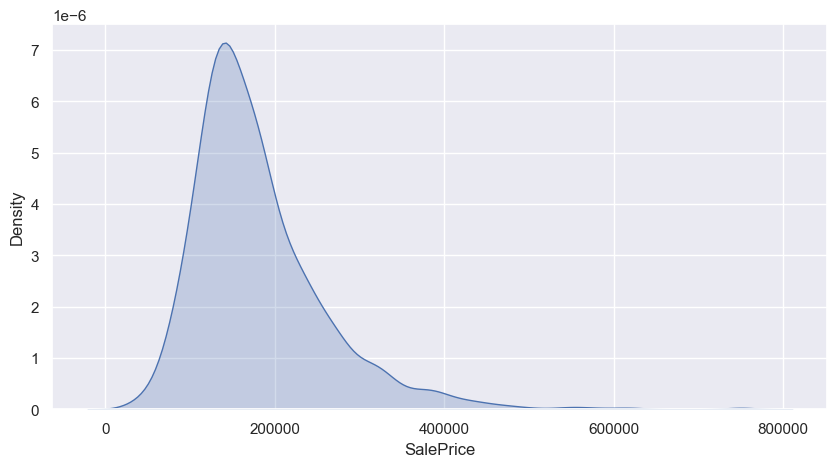

In [97]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.kdeplot(df_numeric['SalePrice'], fill=True)

#### Right skewed, прологарифмируем

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

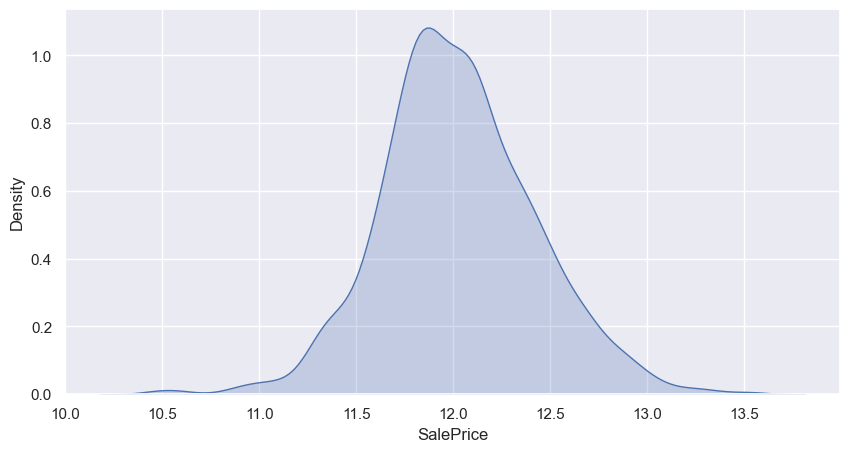

In [98]:
df_numeric['SalePrice'] = np.log1p(df_numeric['SalePrice'])
df_categorical['SalePrice'] = np.log1p(train['SalePrice'])
sns.kdeplot(df_numeric['SalePrice'], fill=True)

#### Так лучше

### Построим графички

### Pairplot не вывозит поэтому только так(

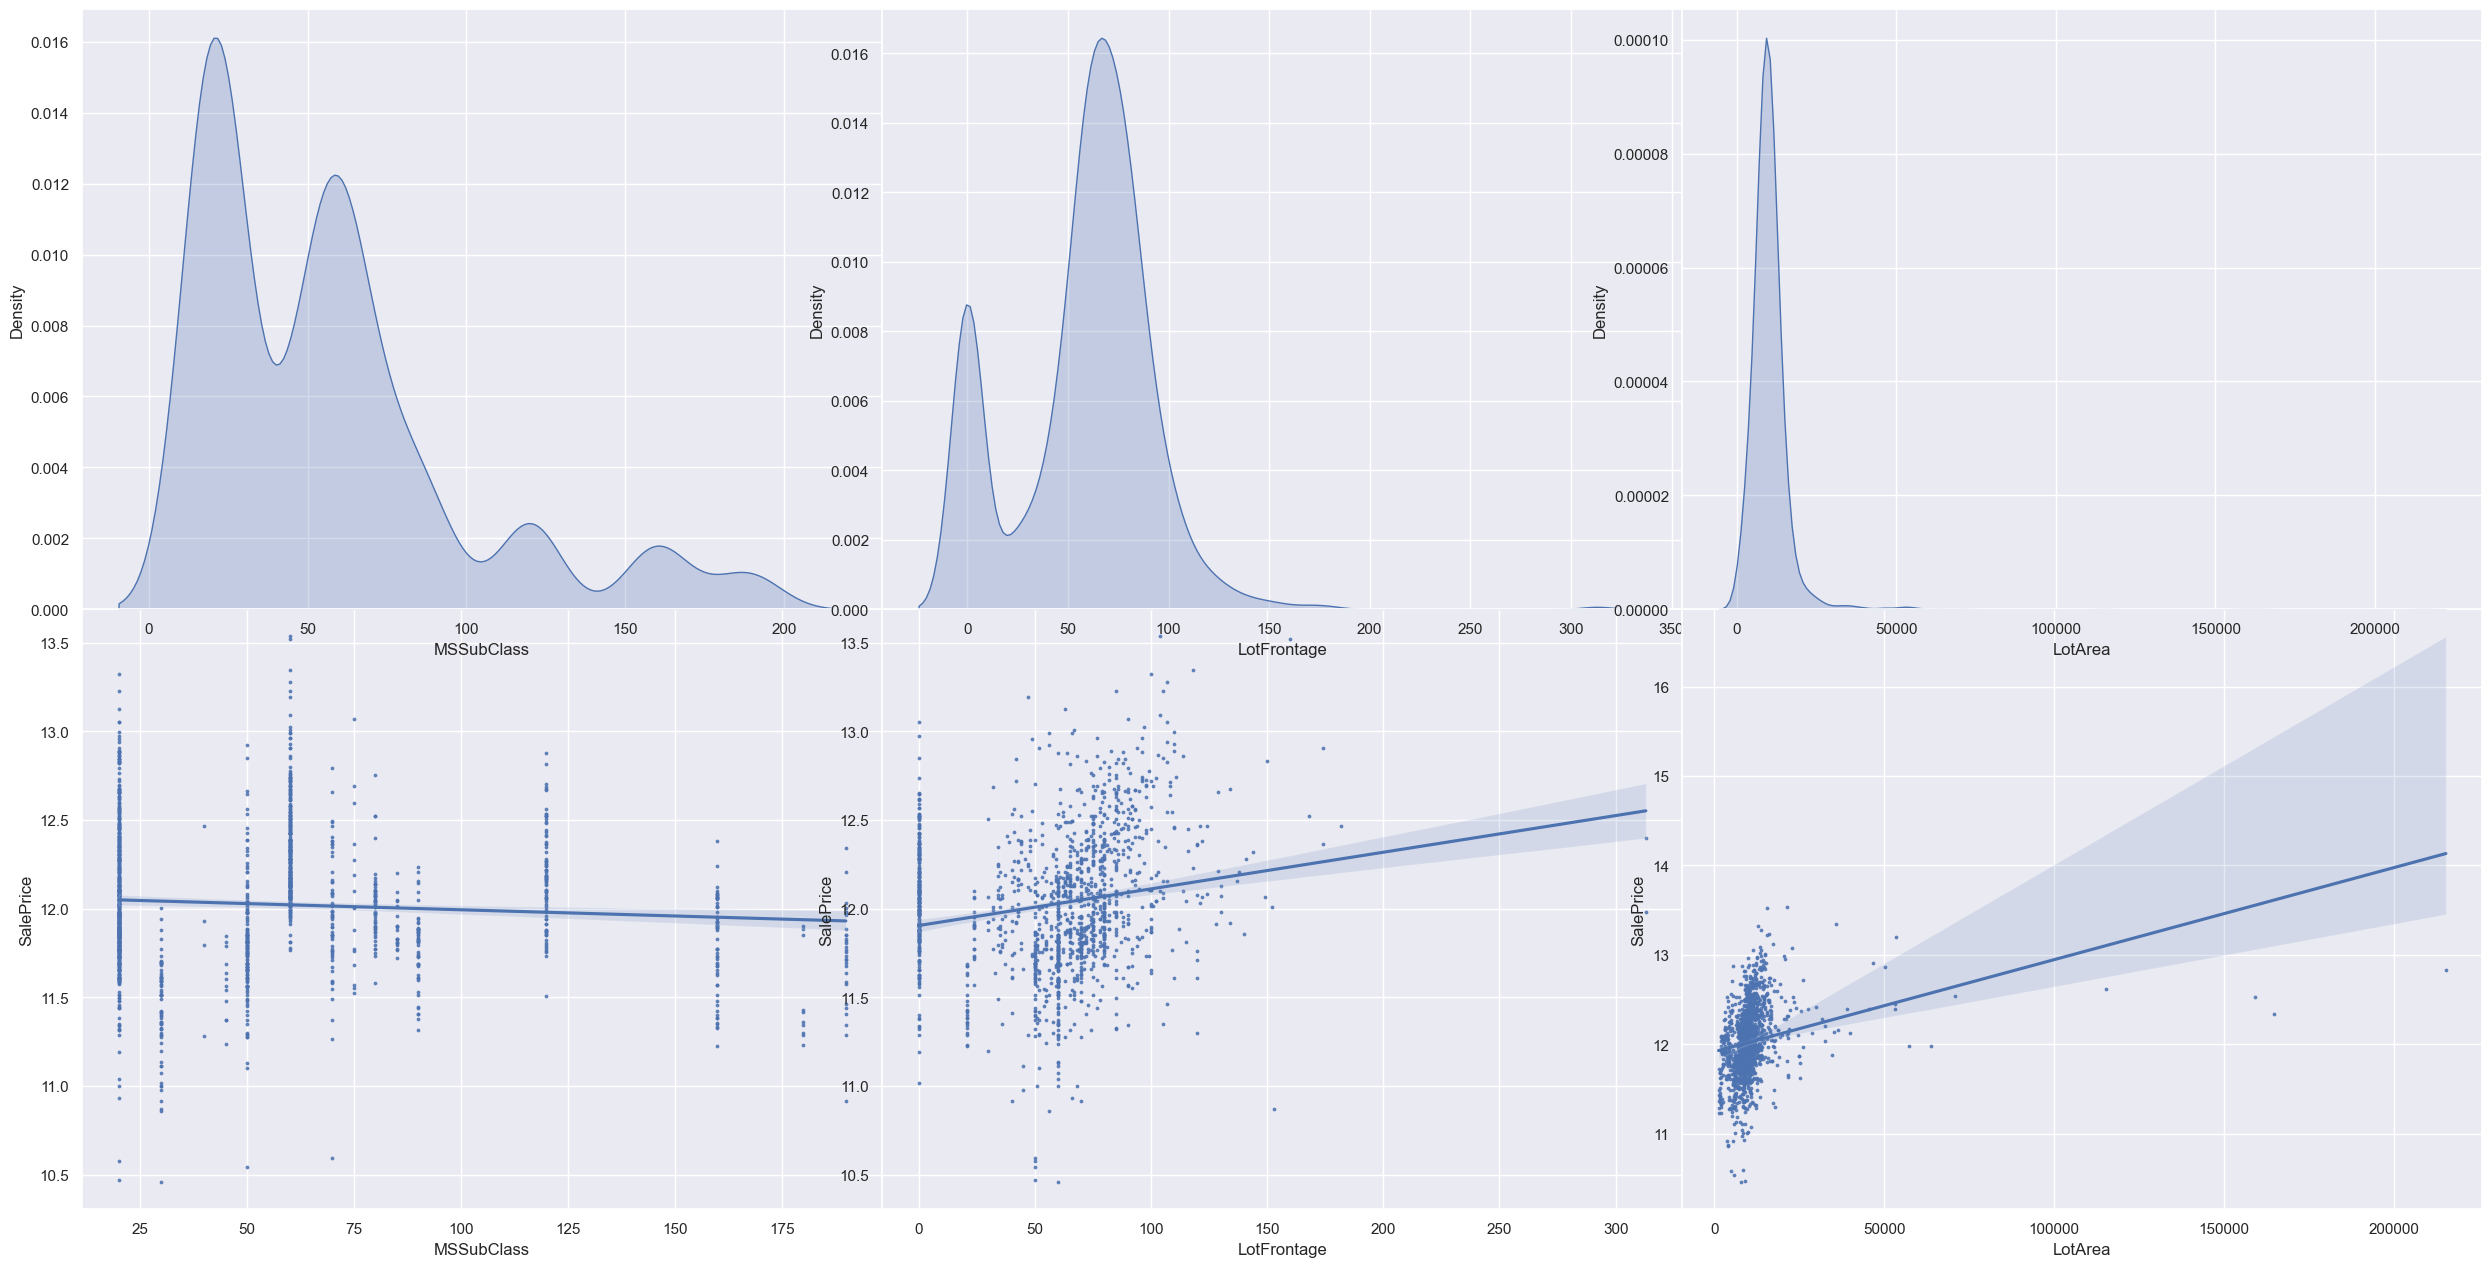

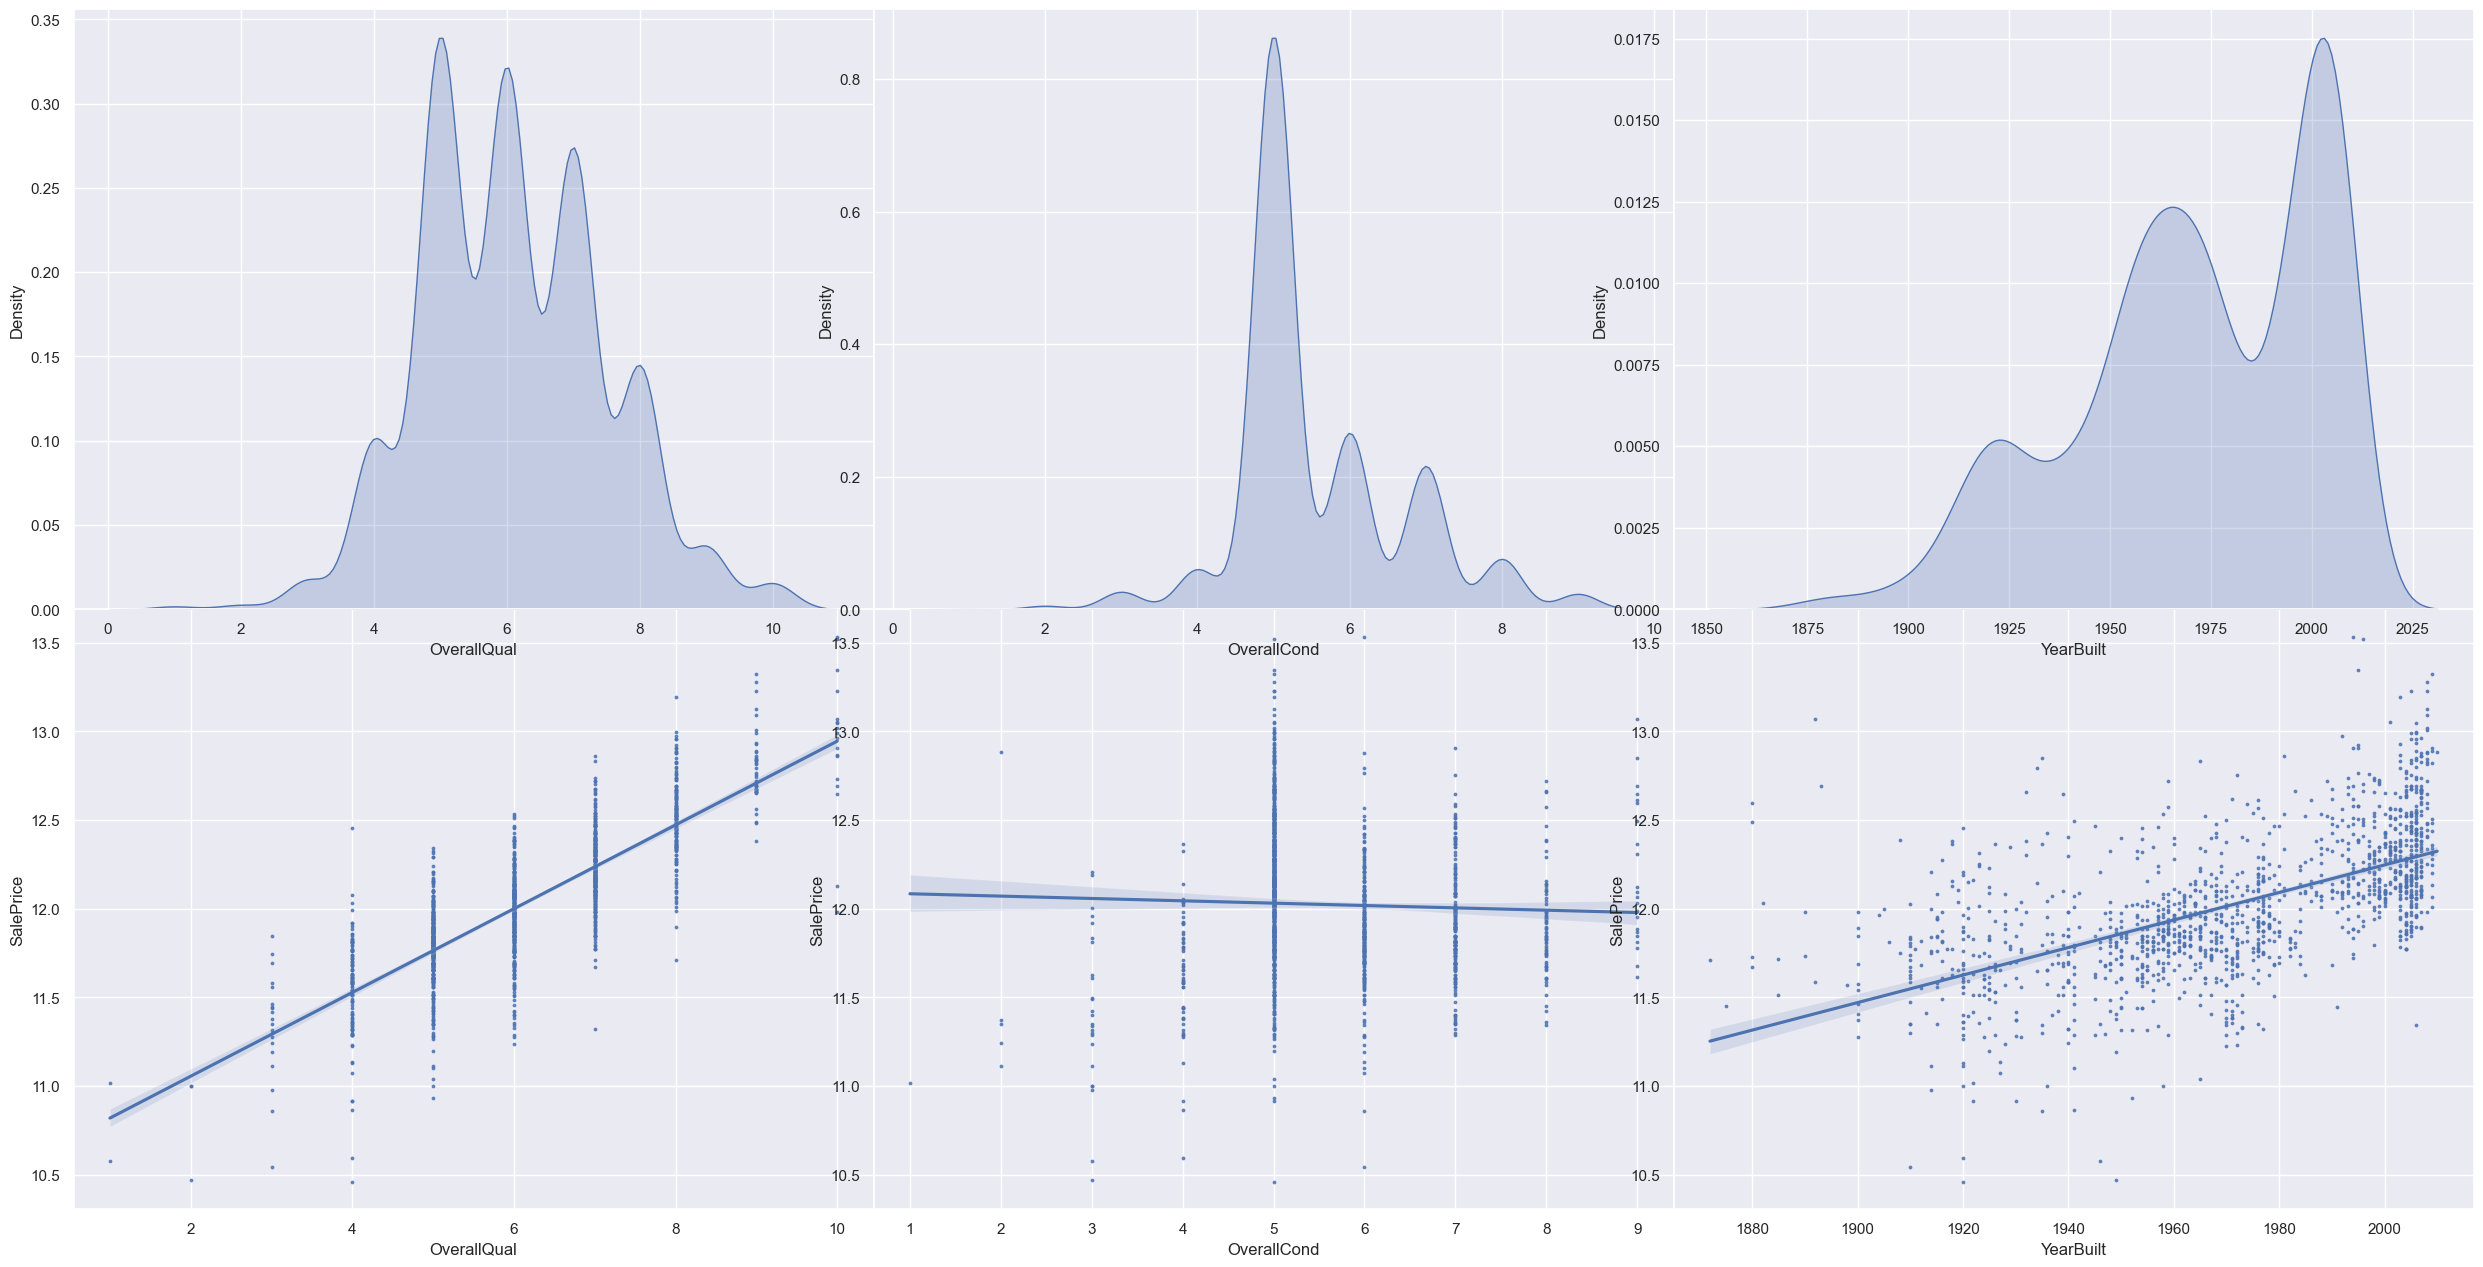

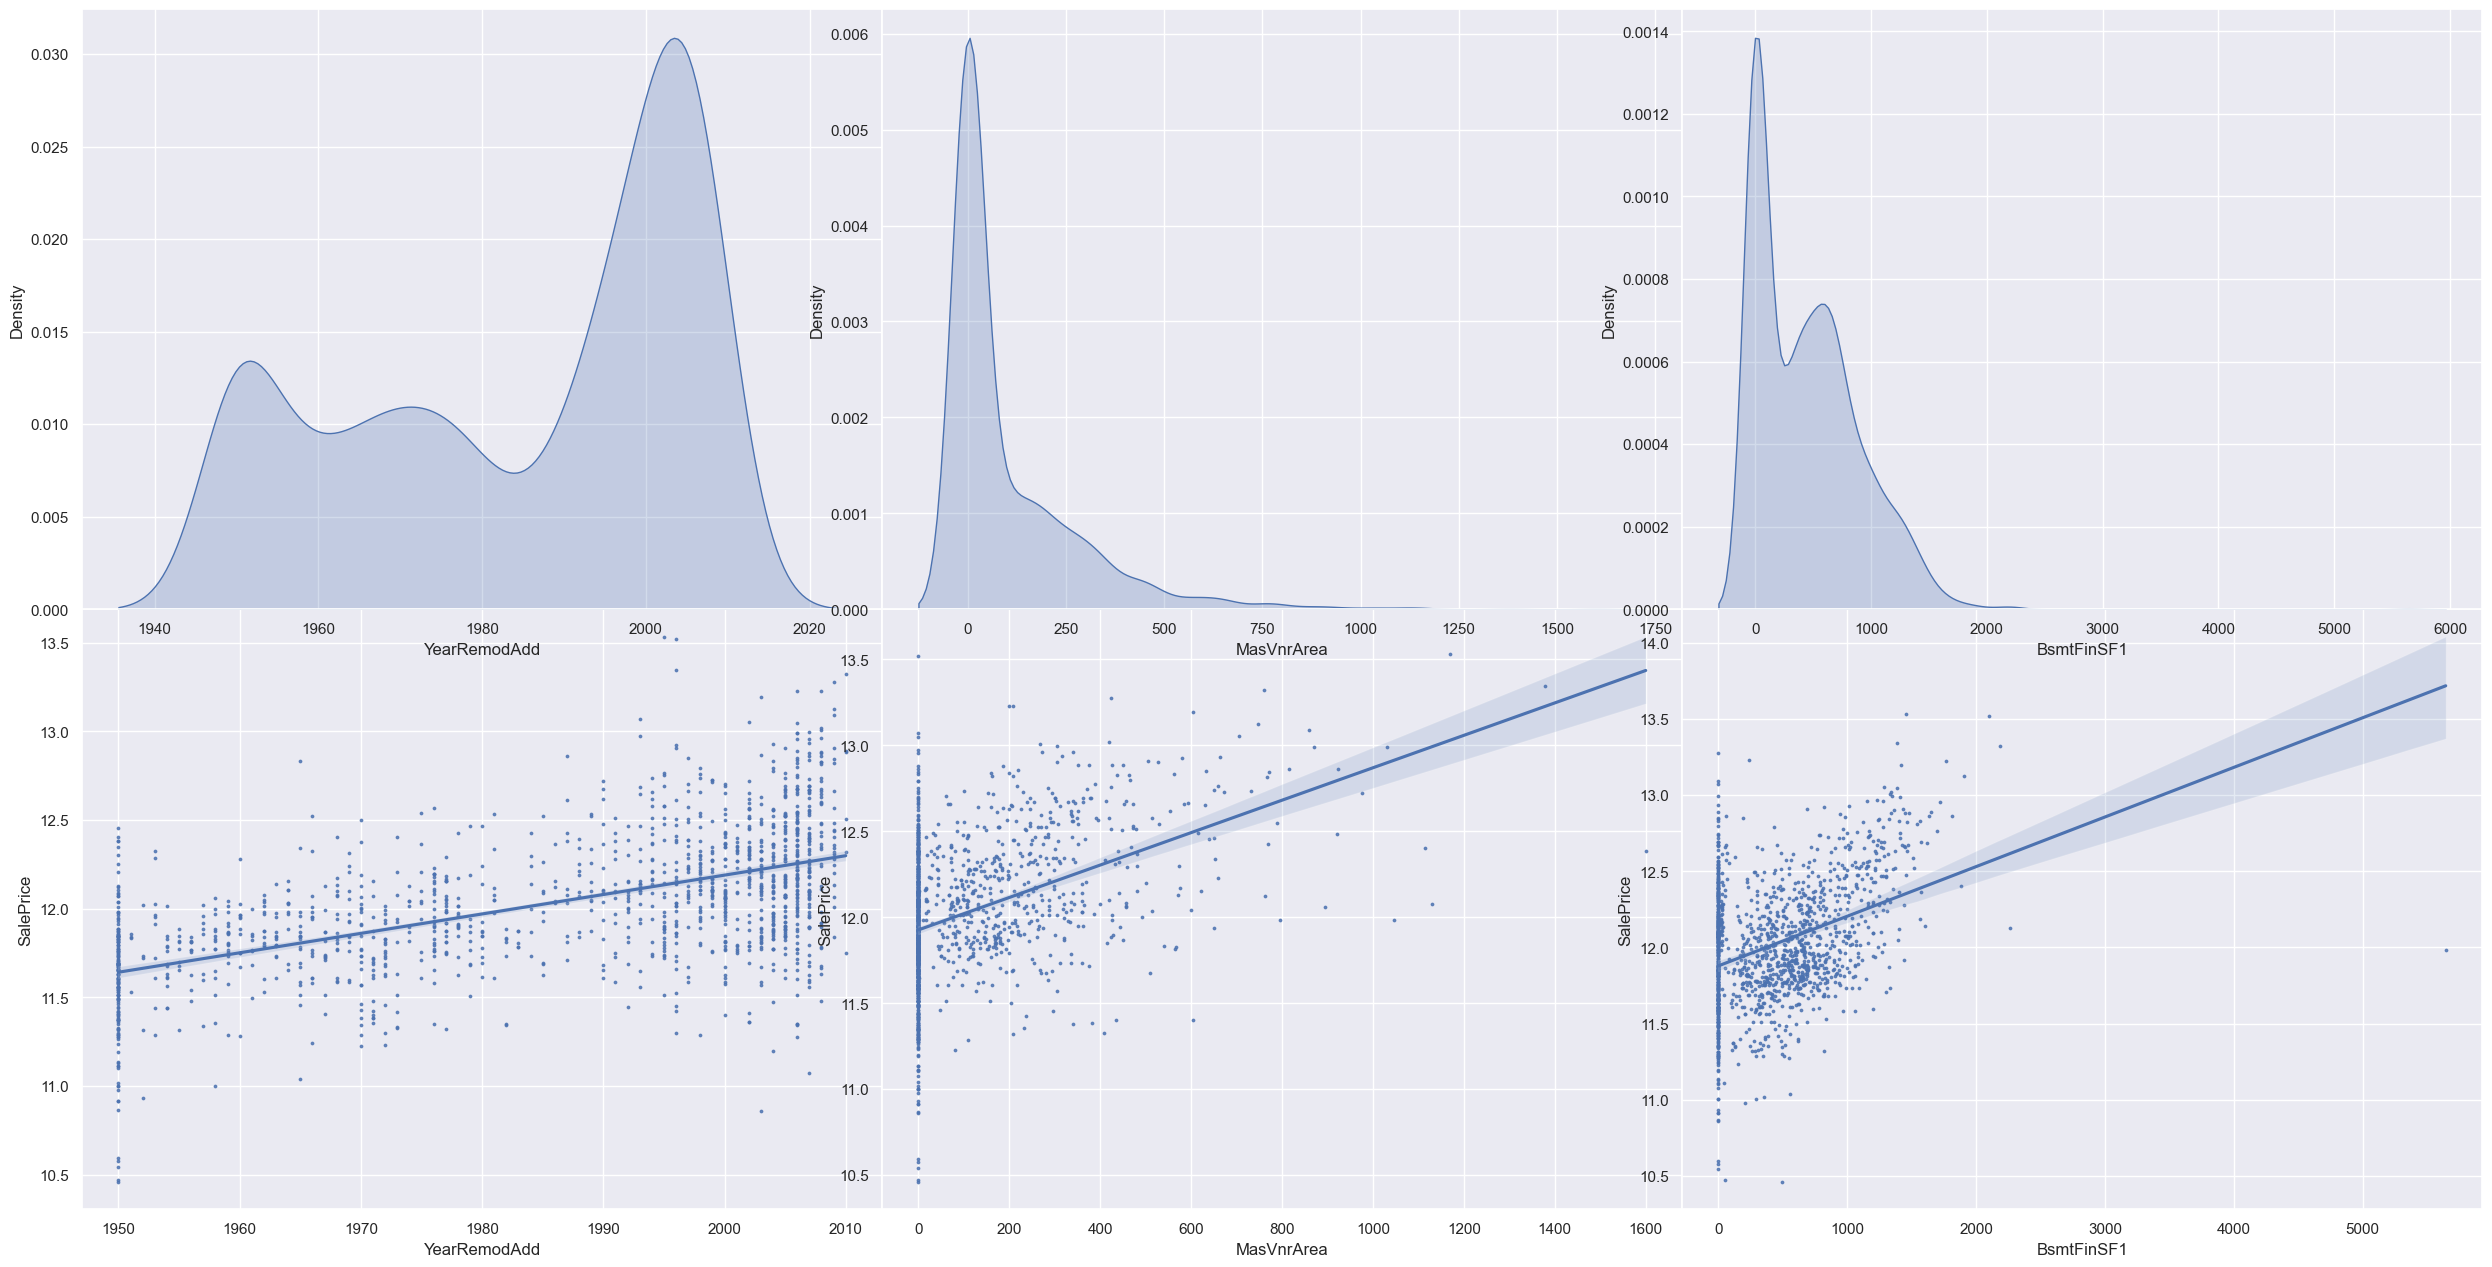

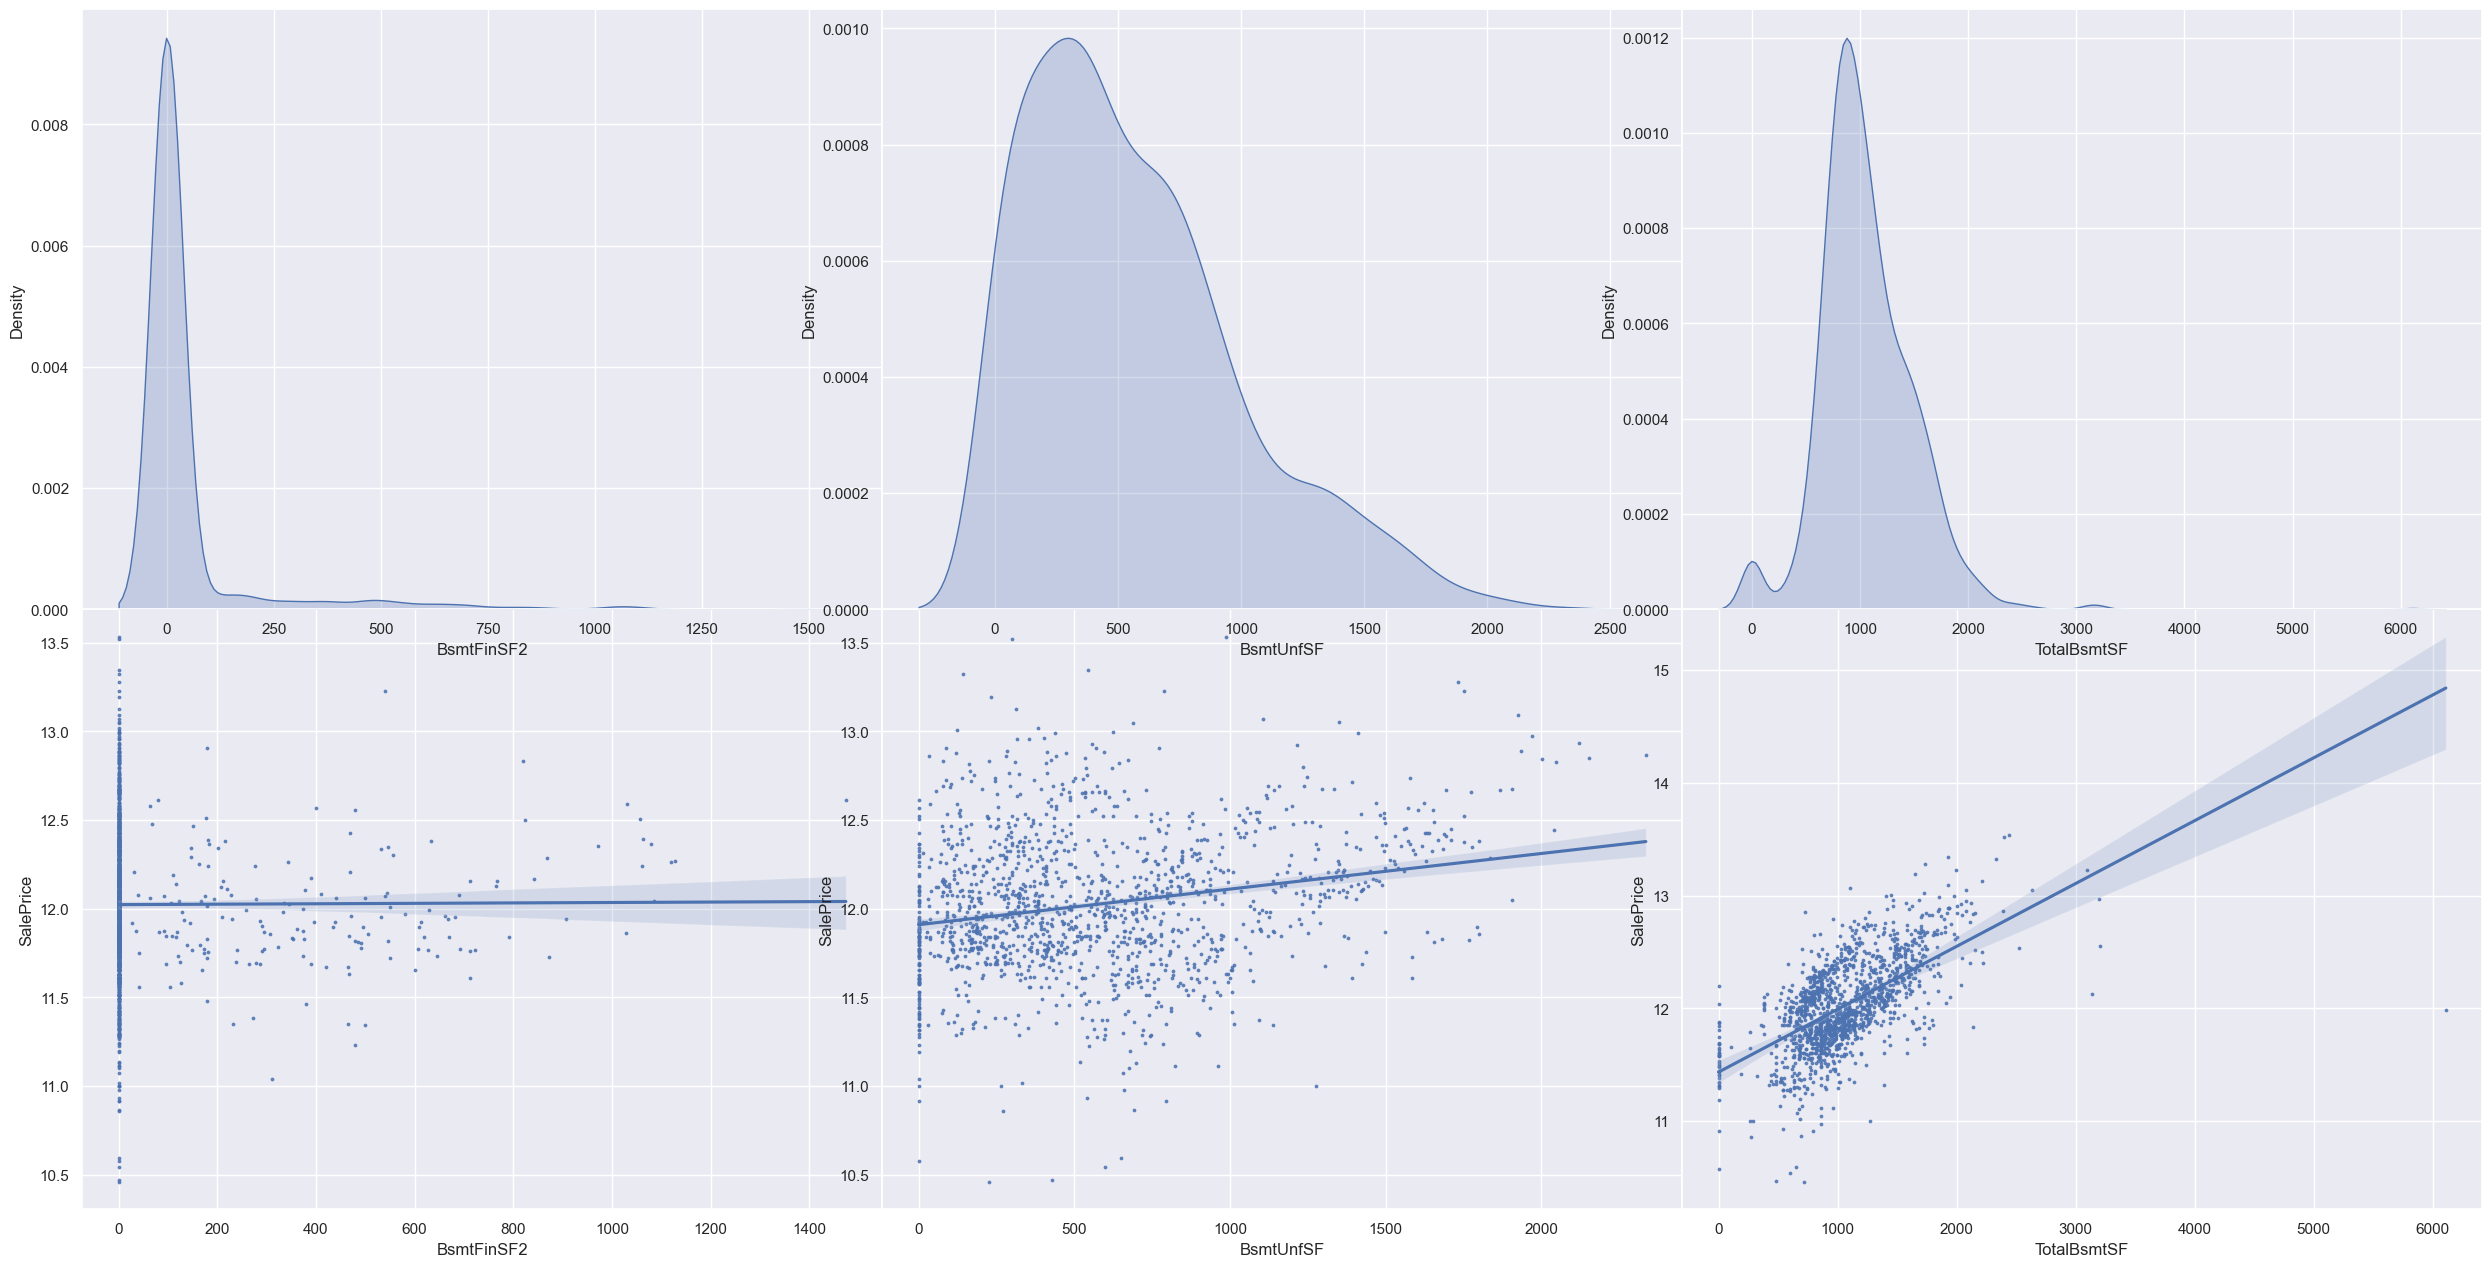

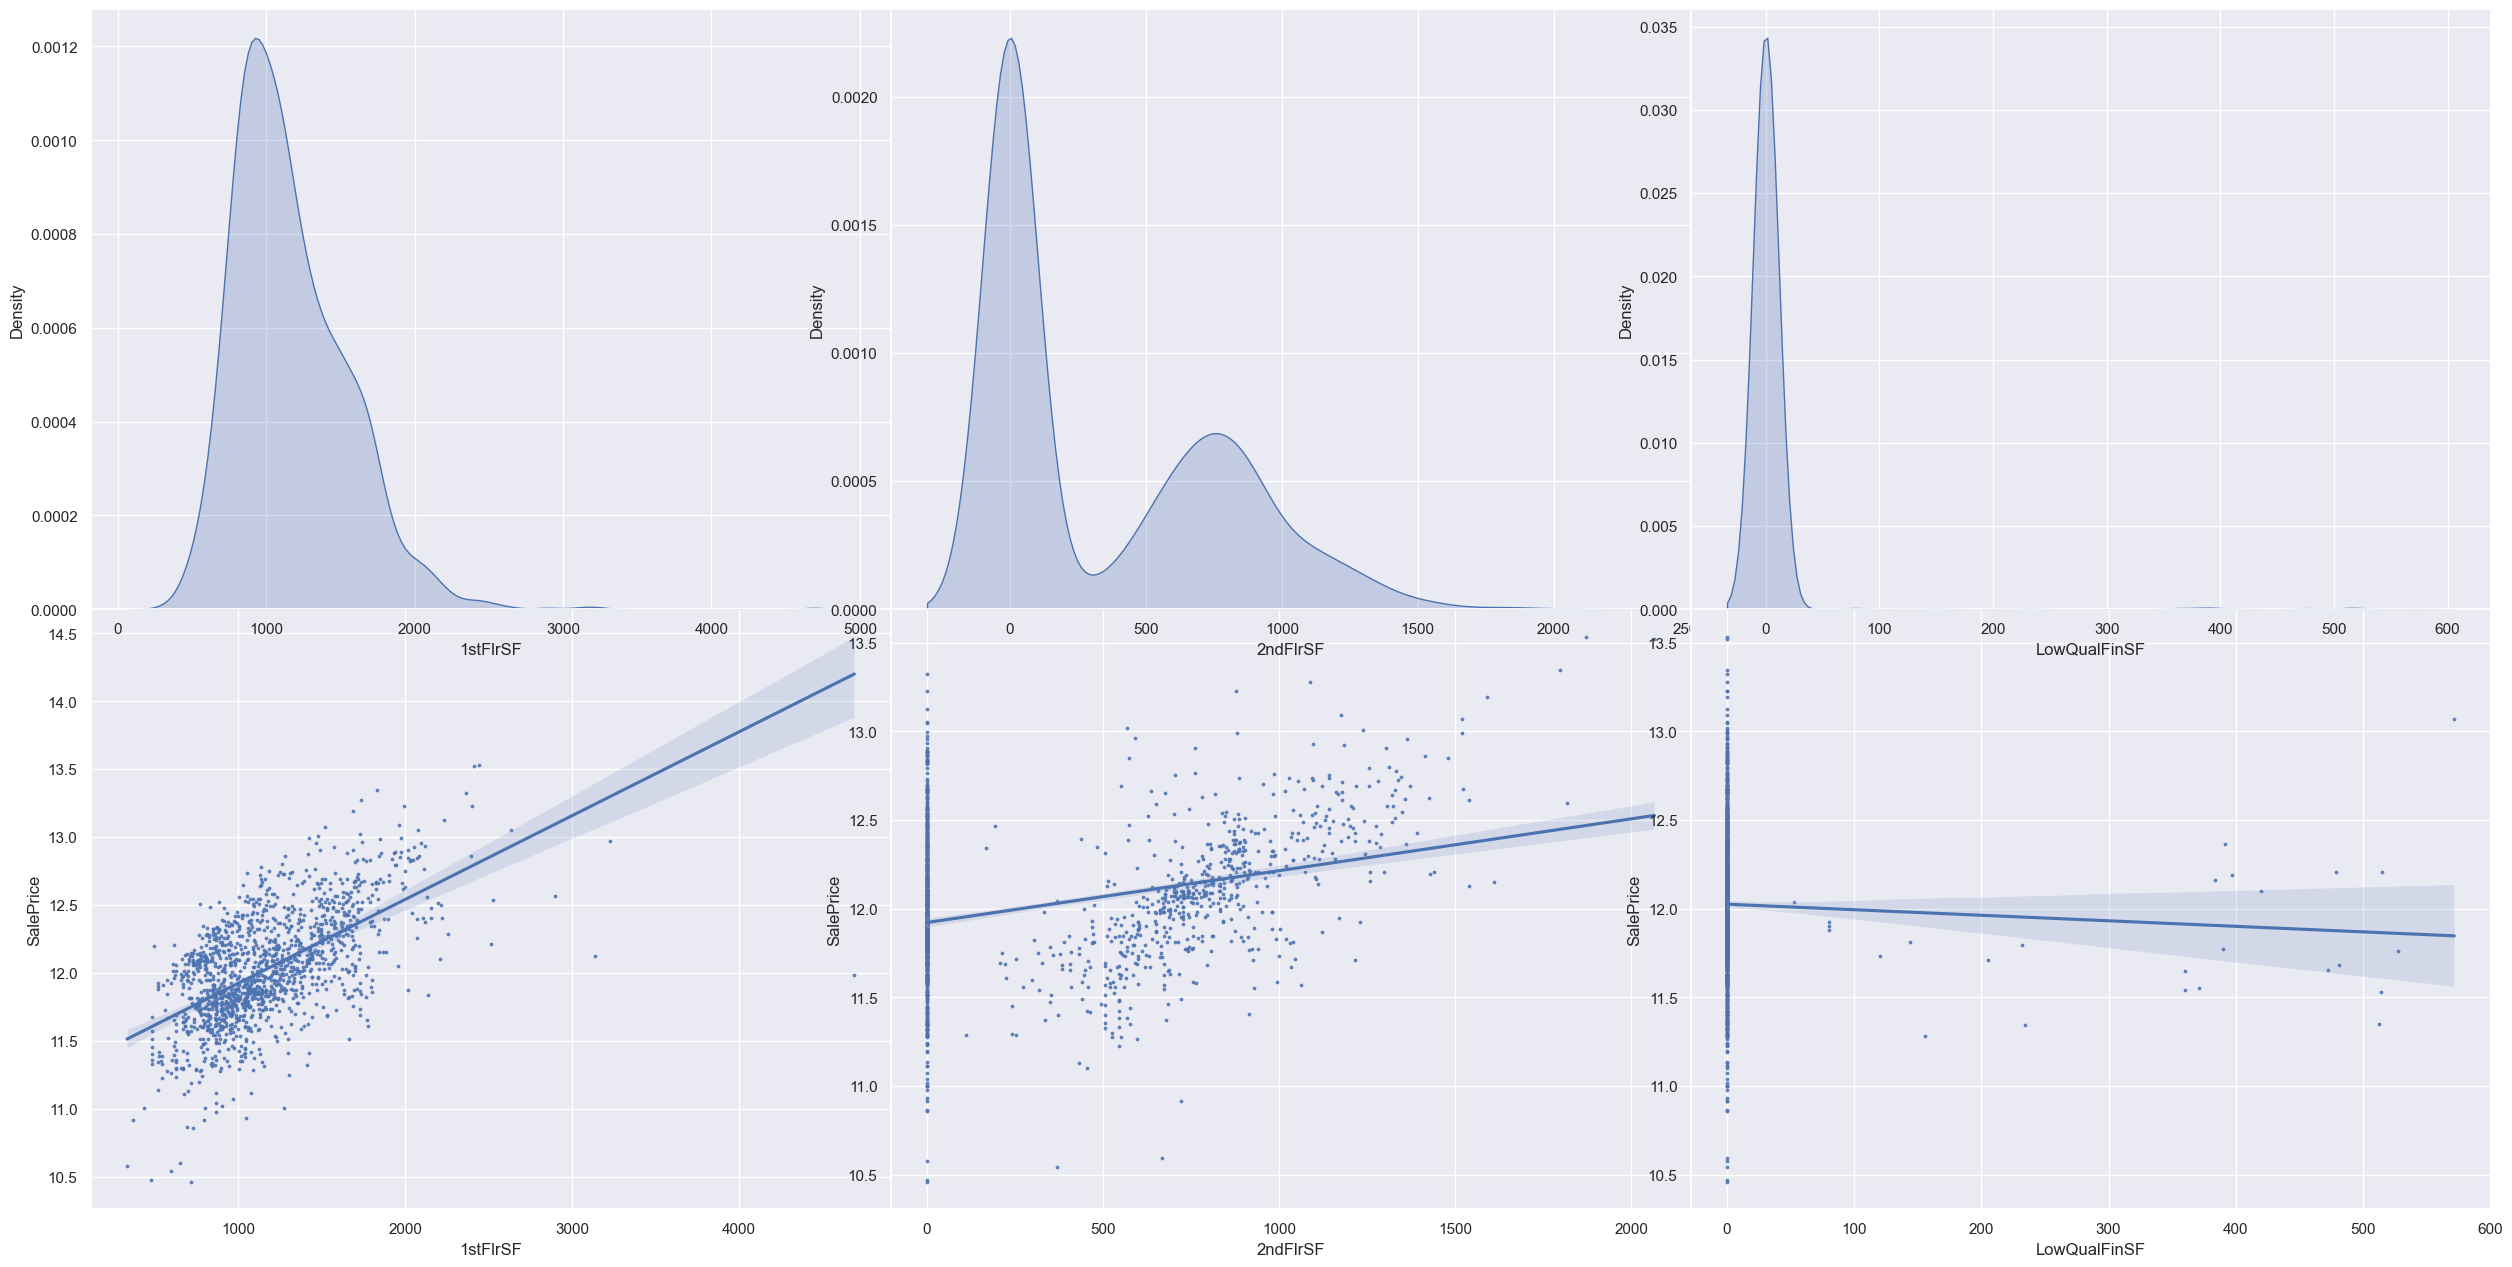

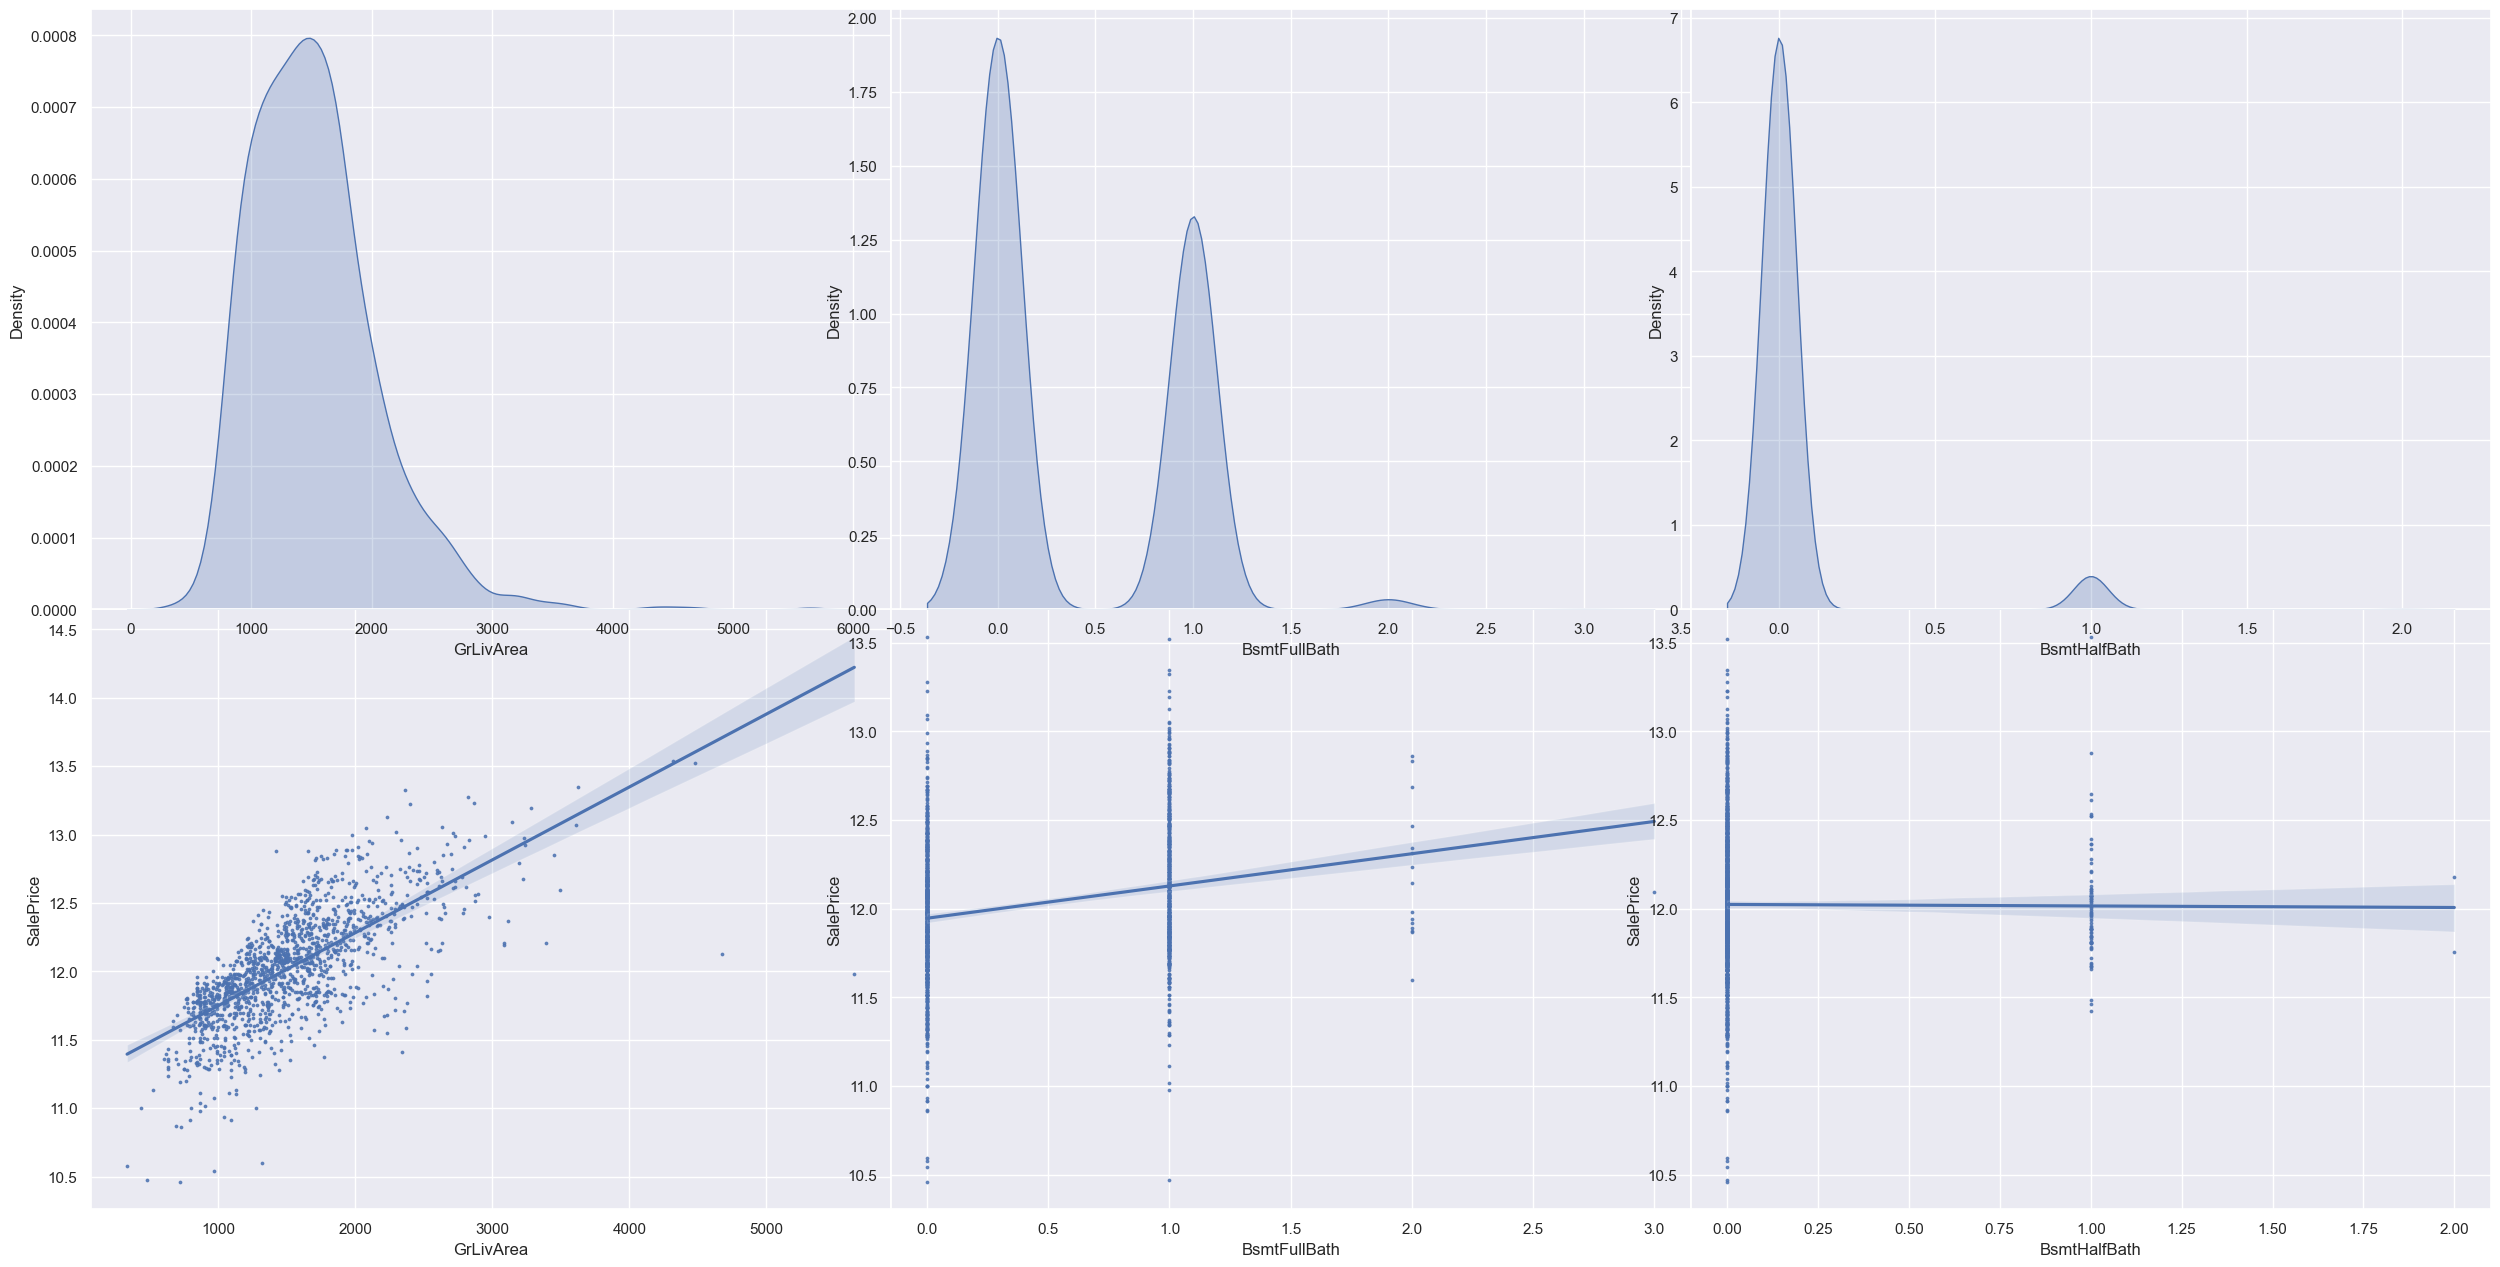

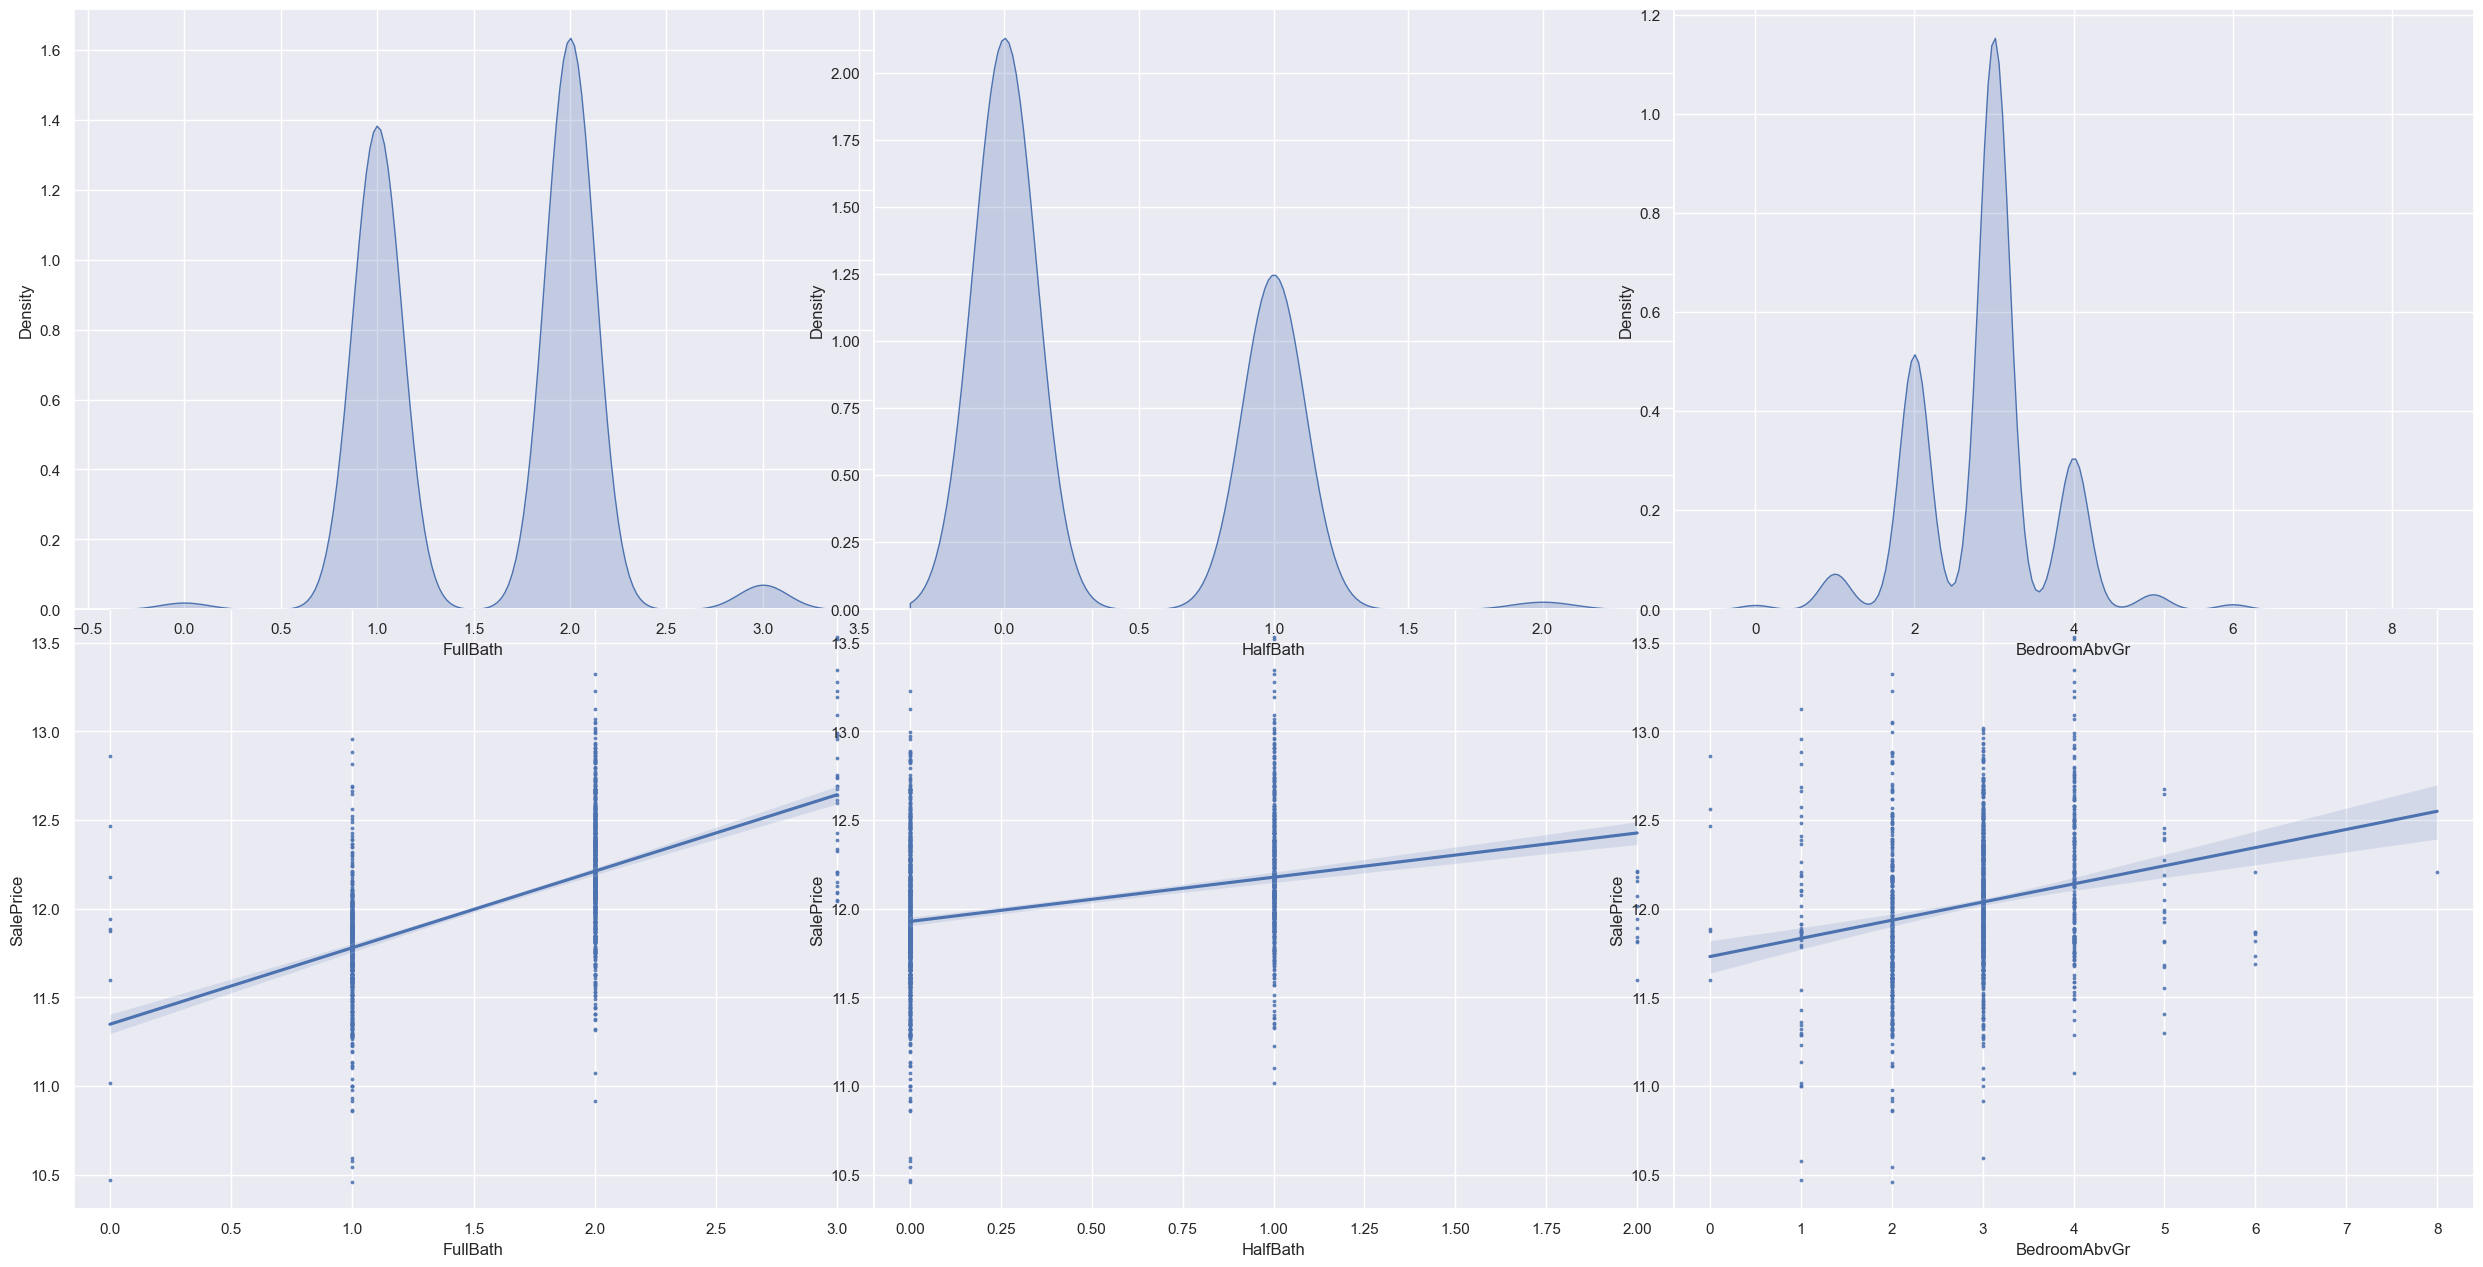

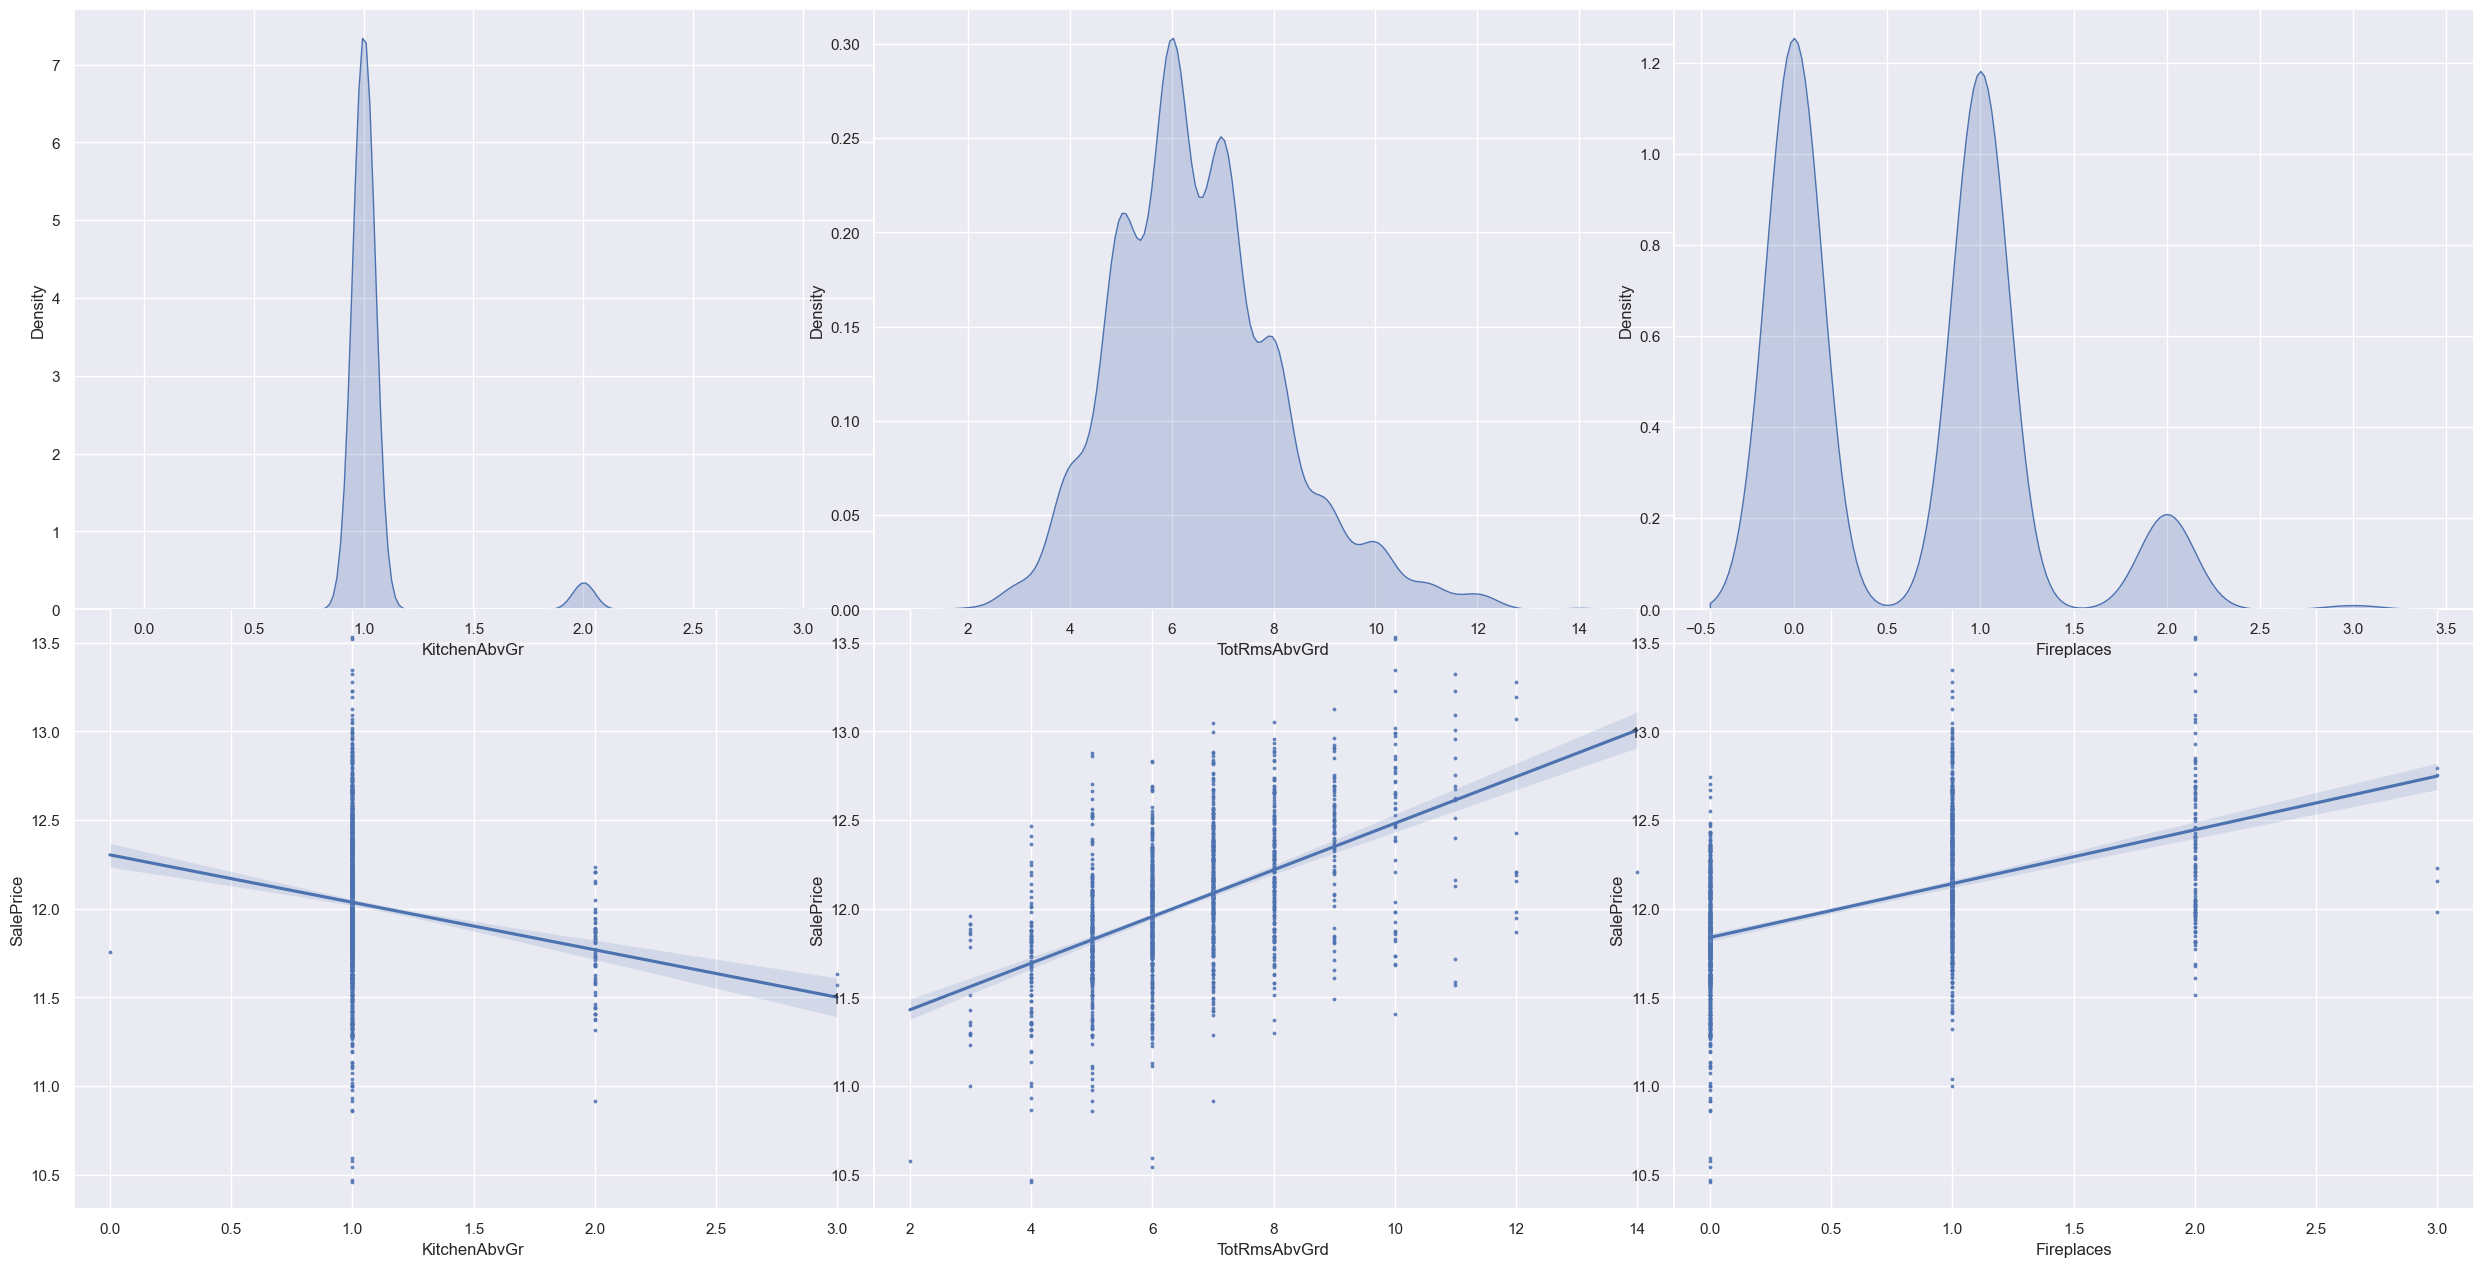

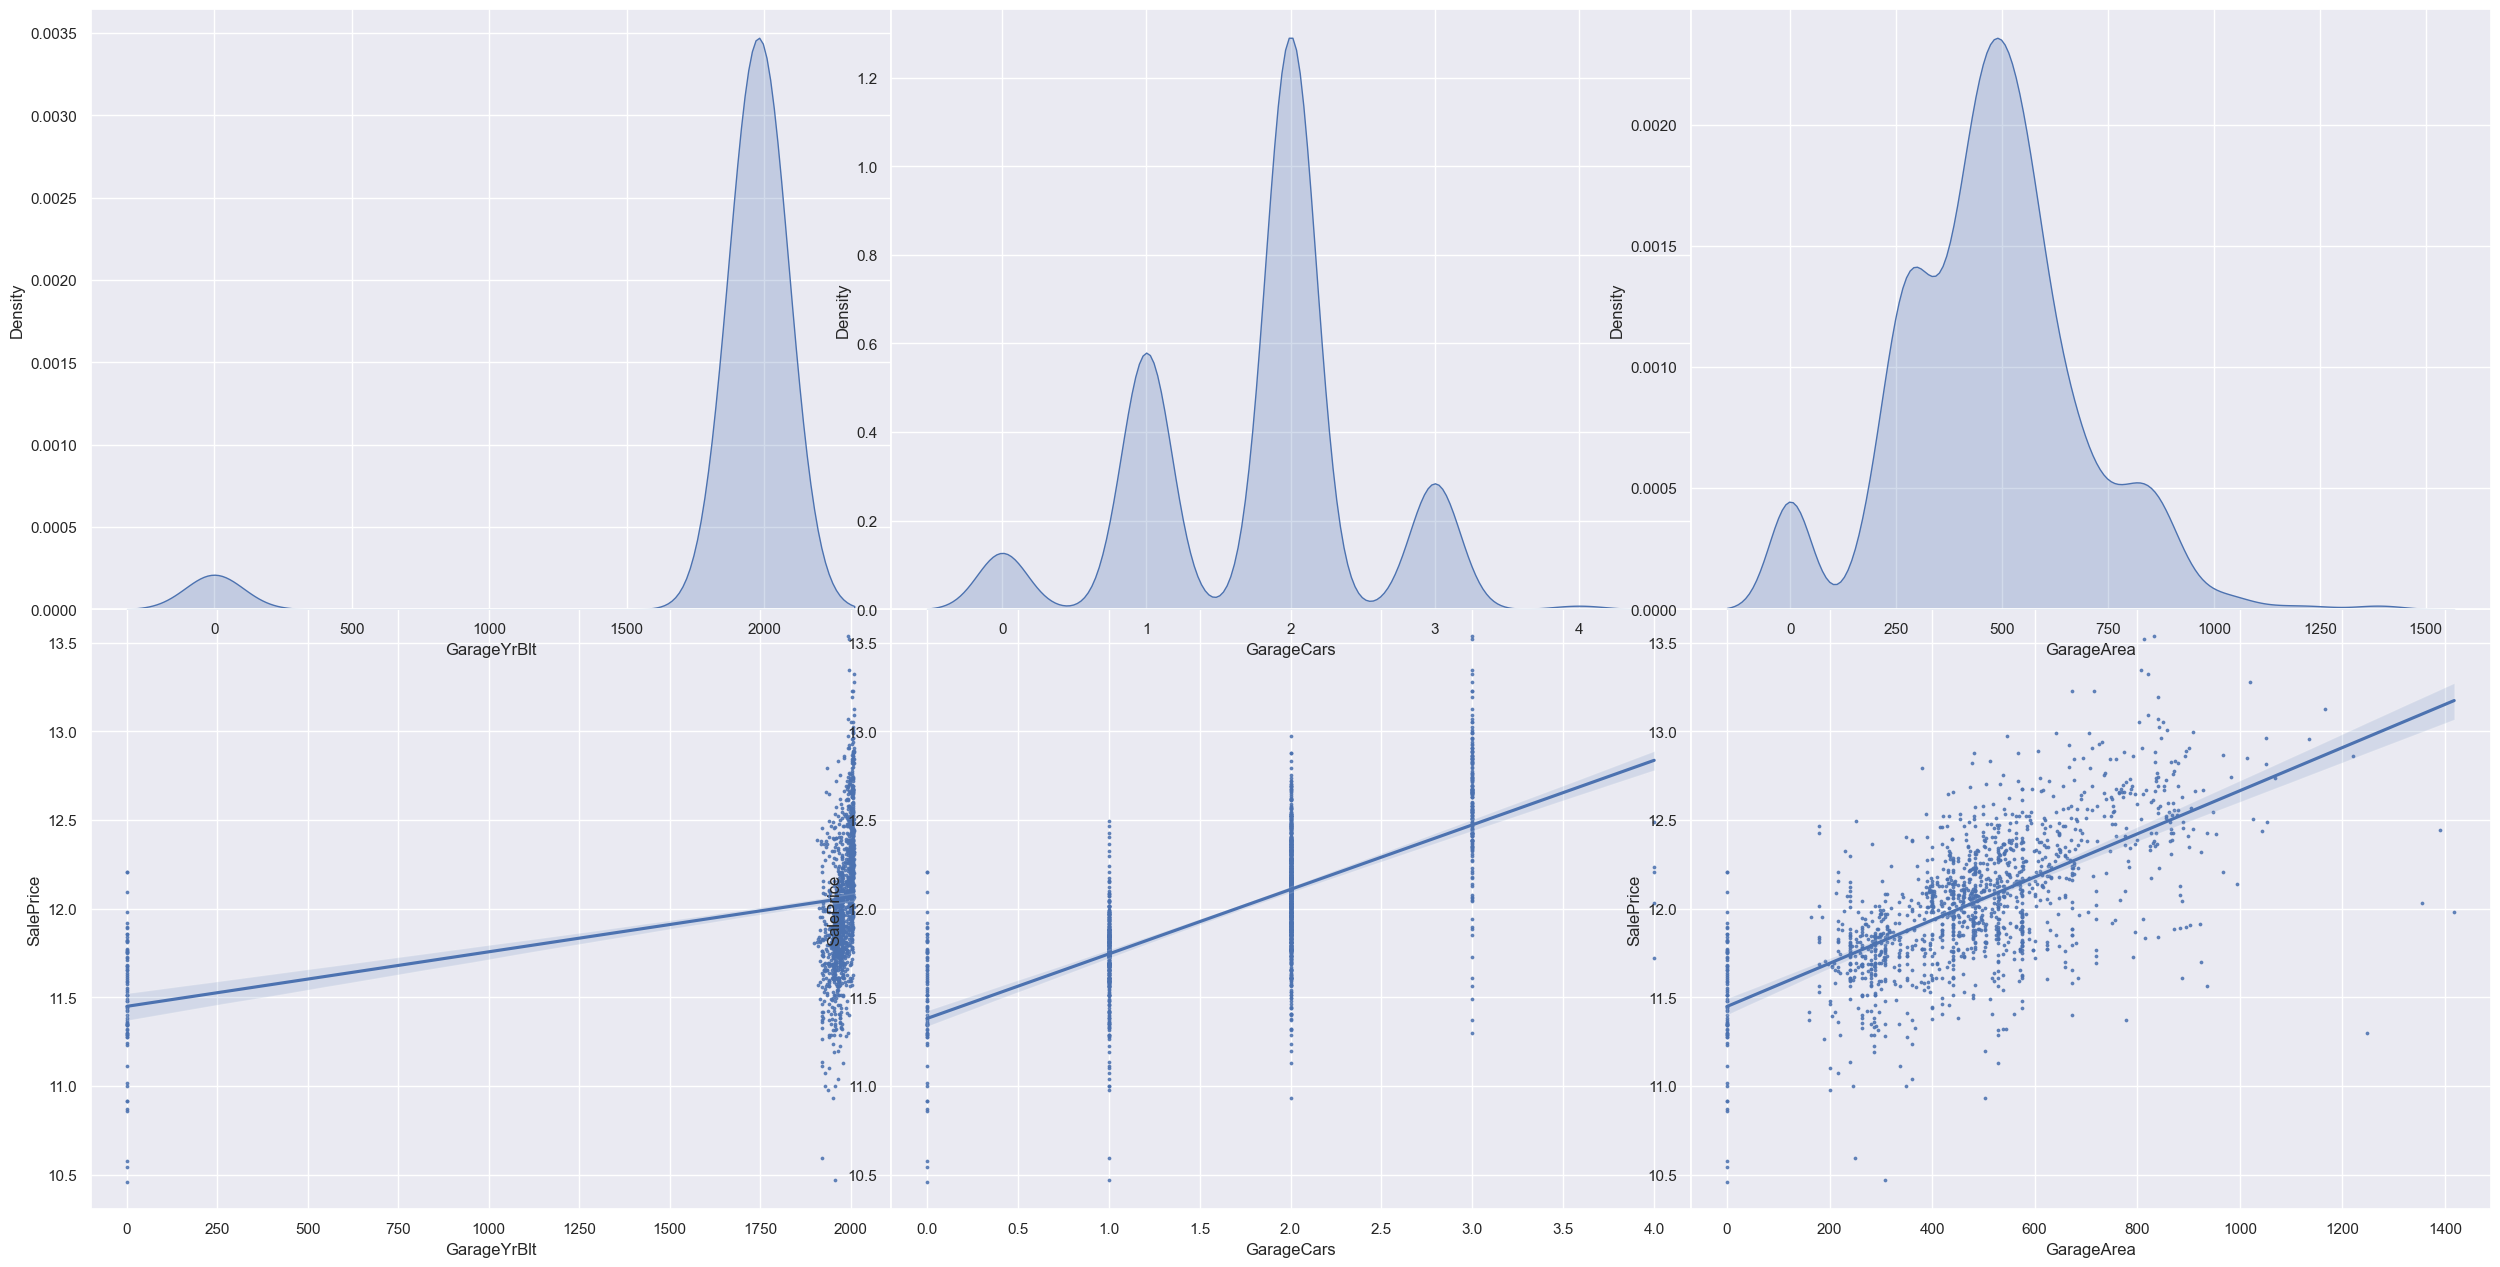

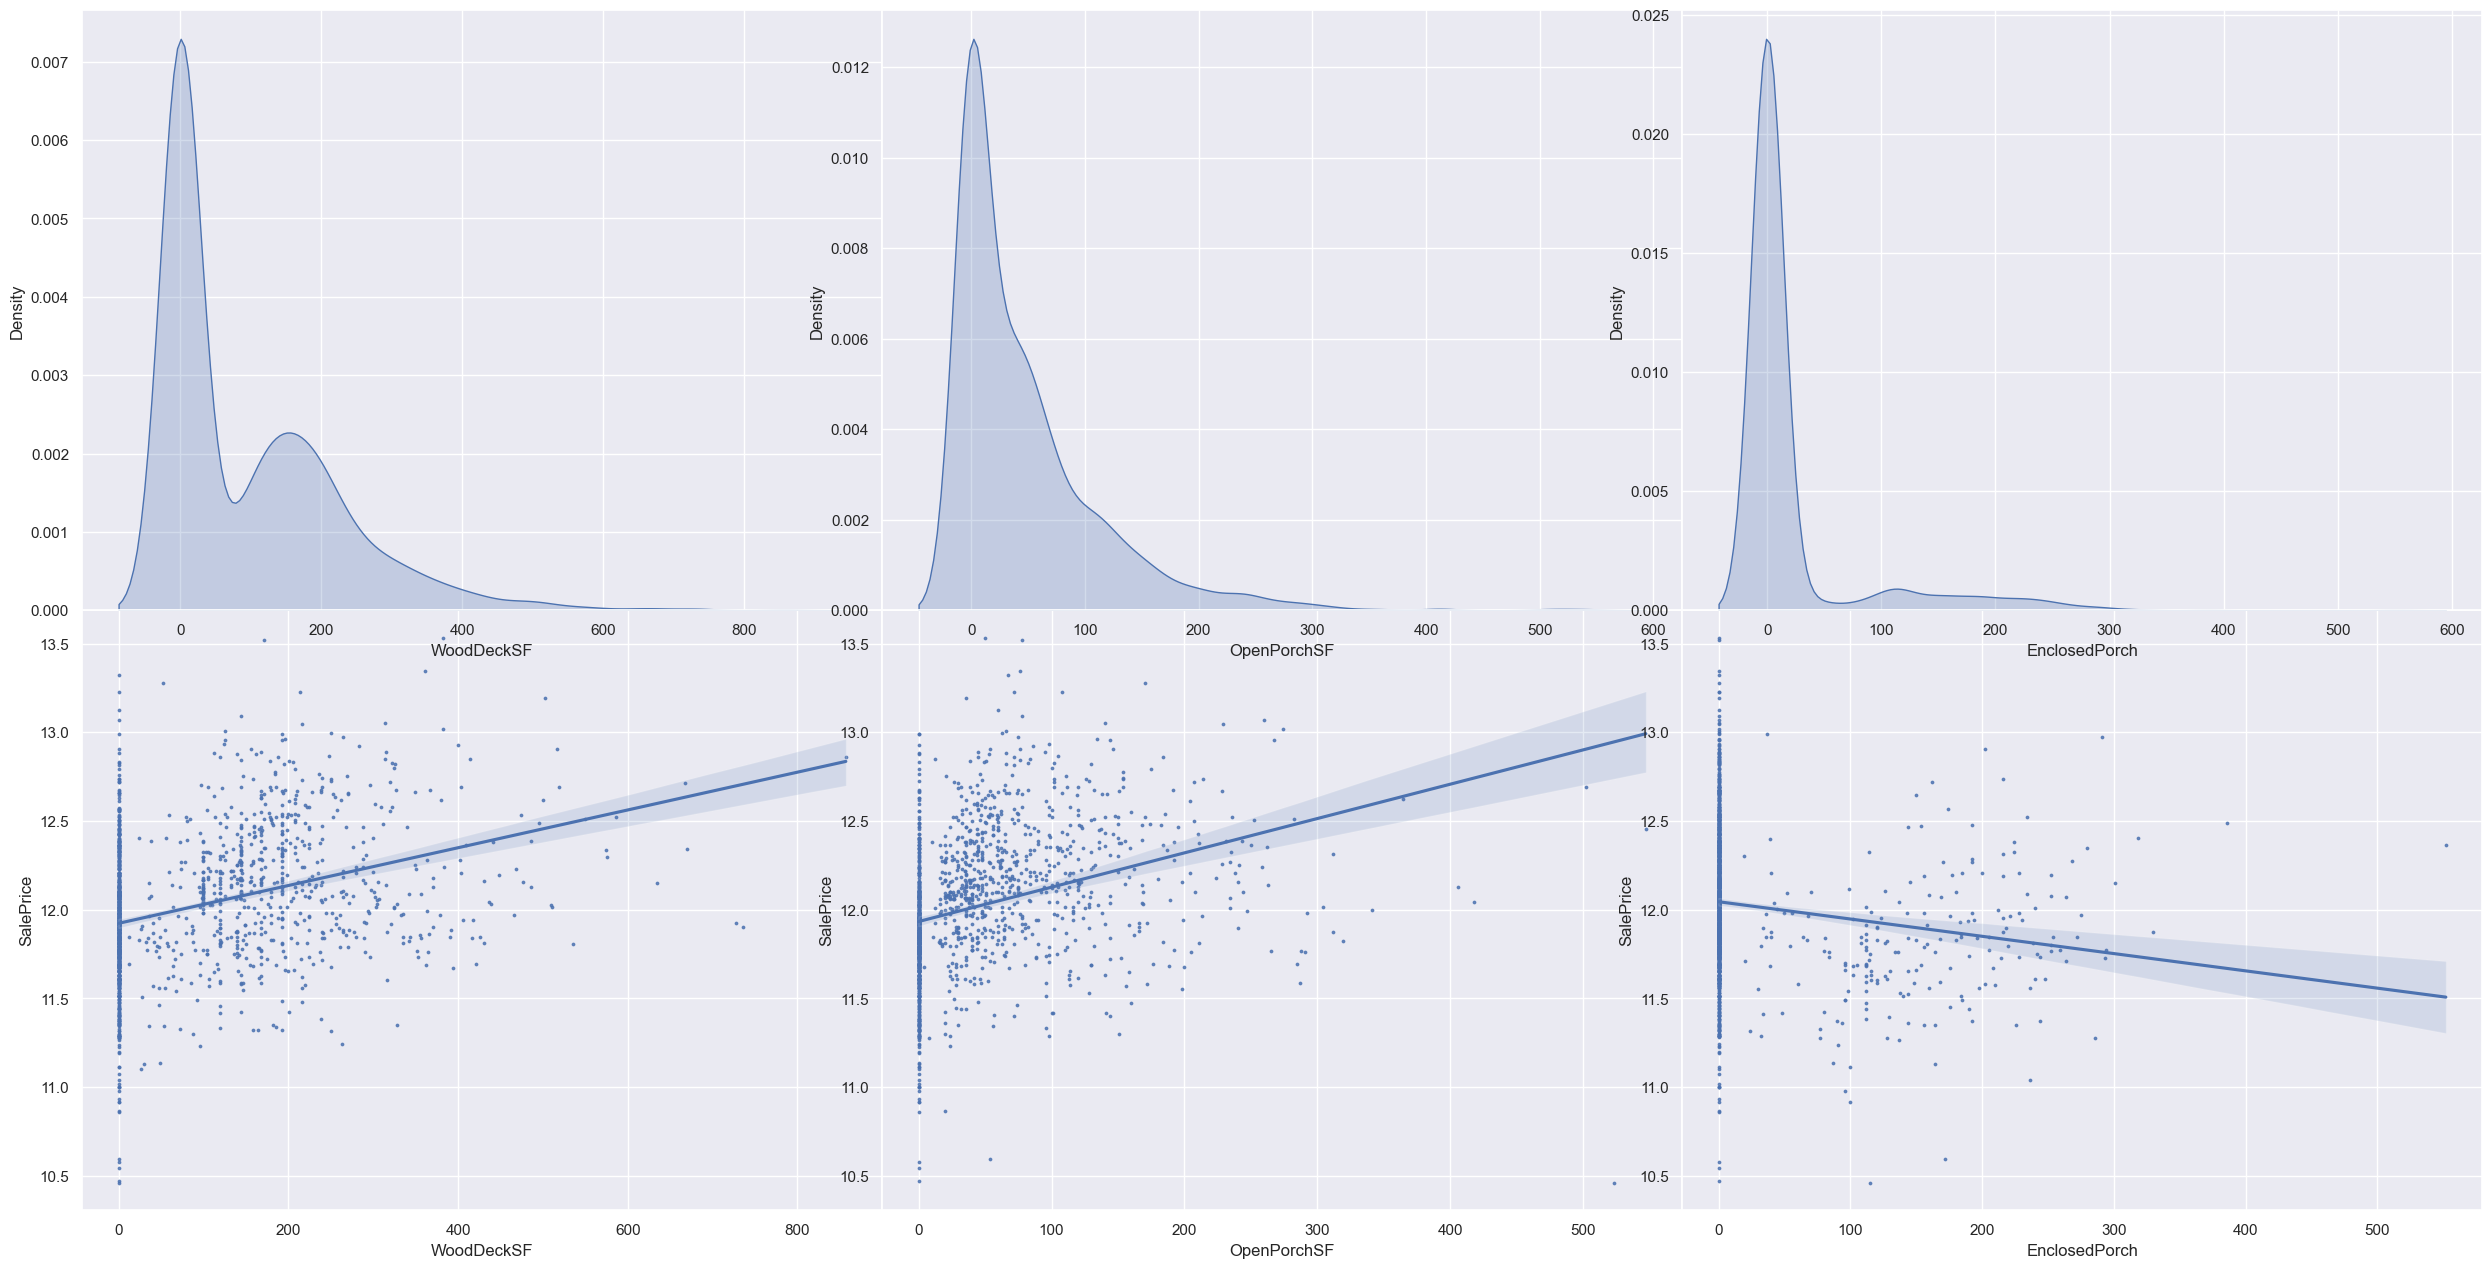

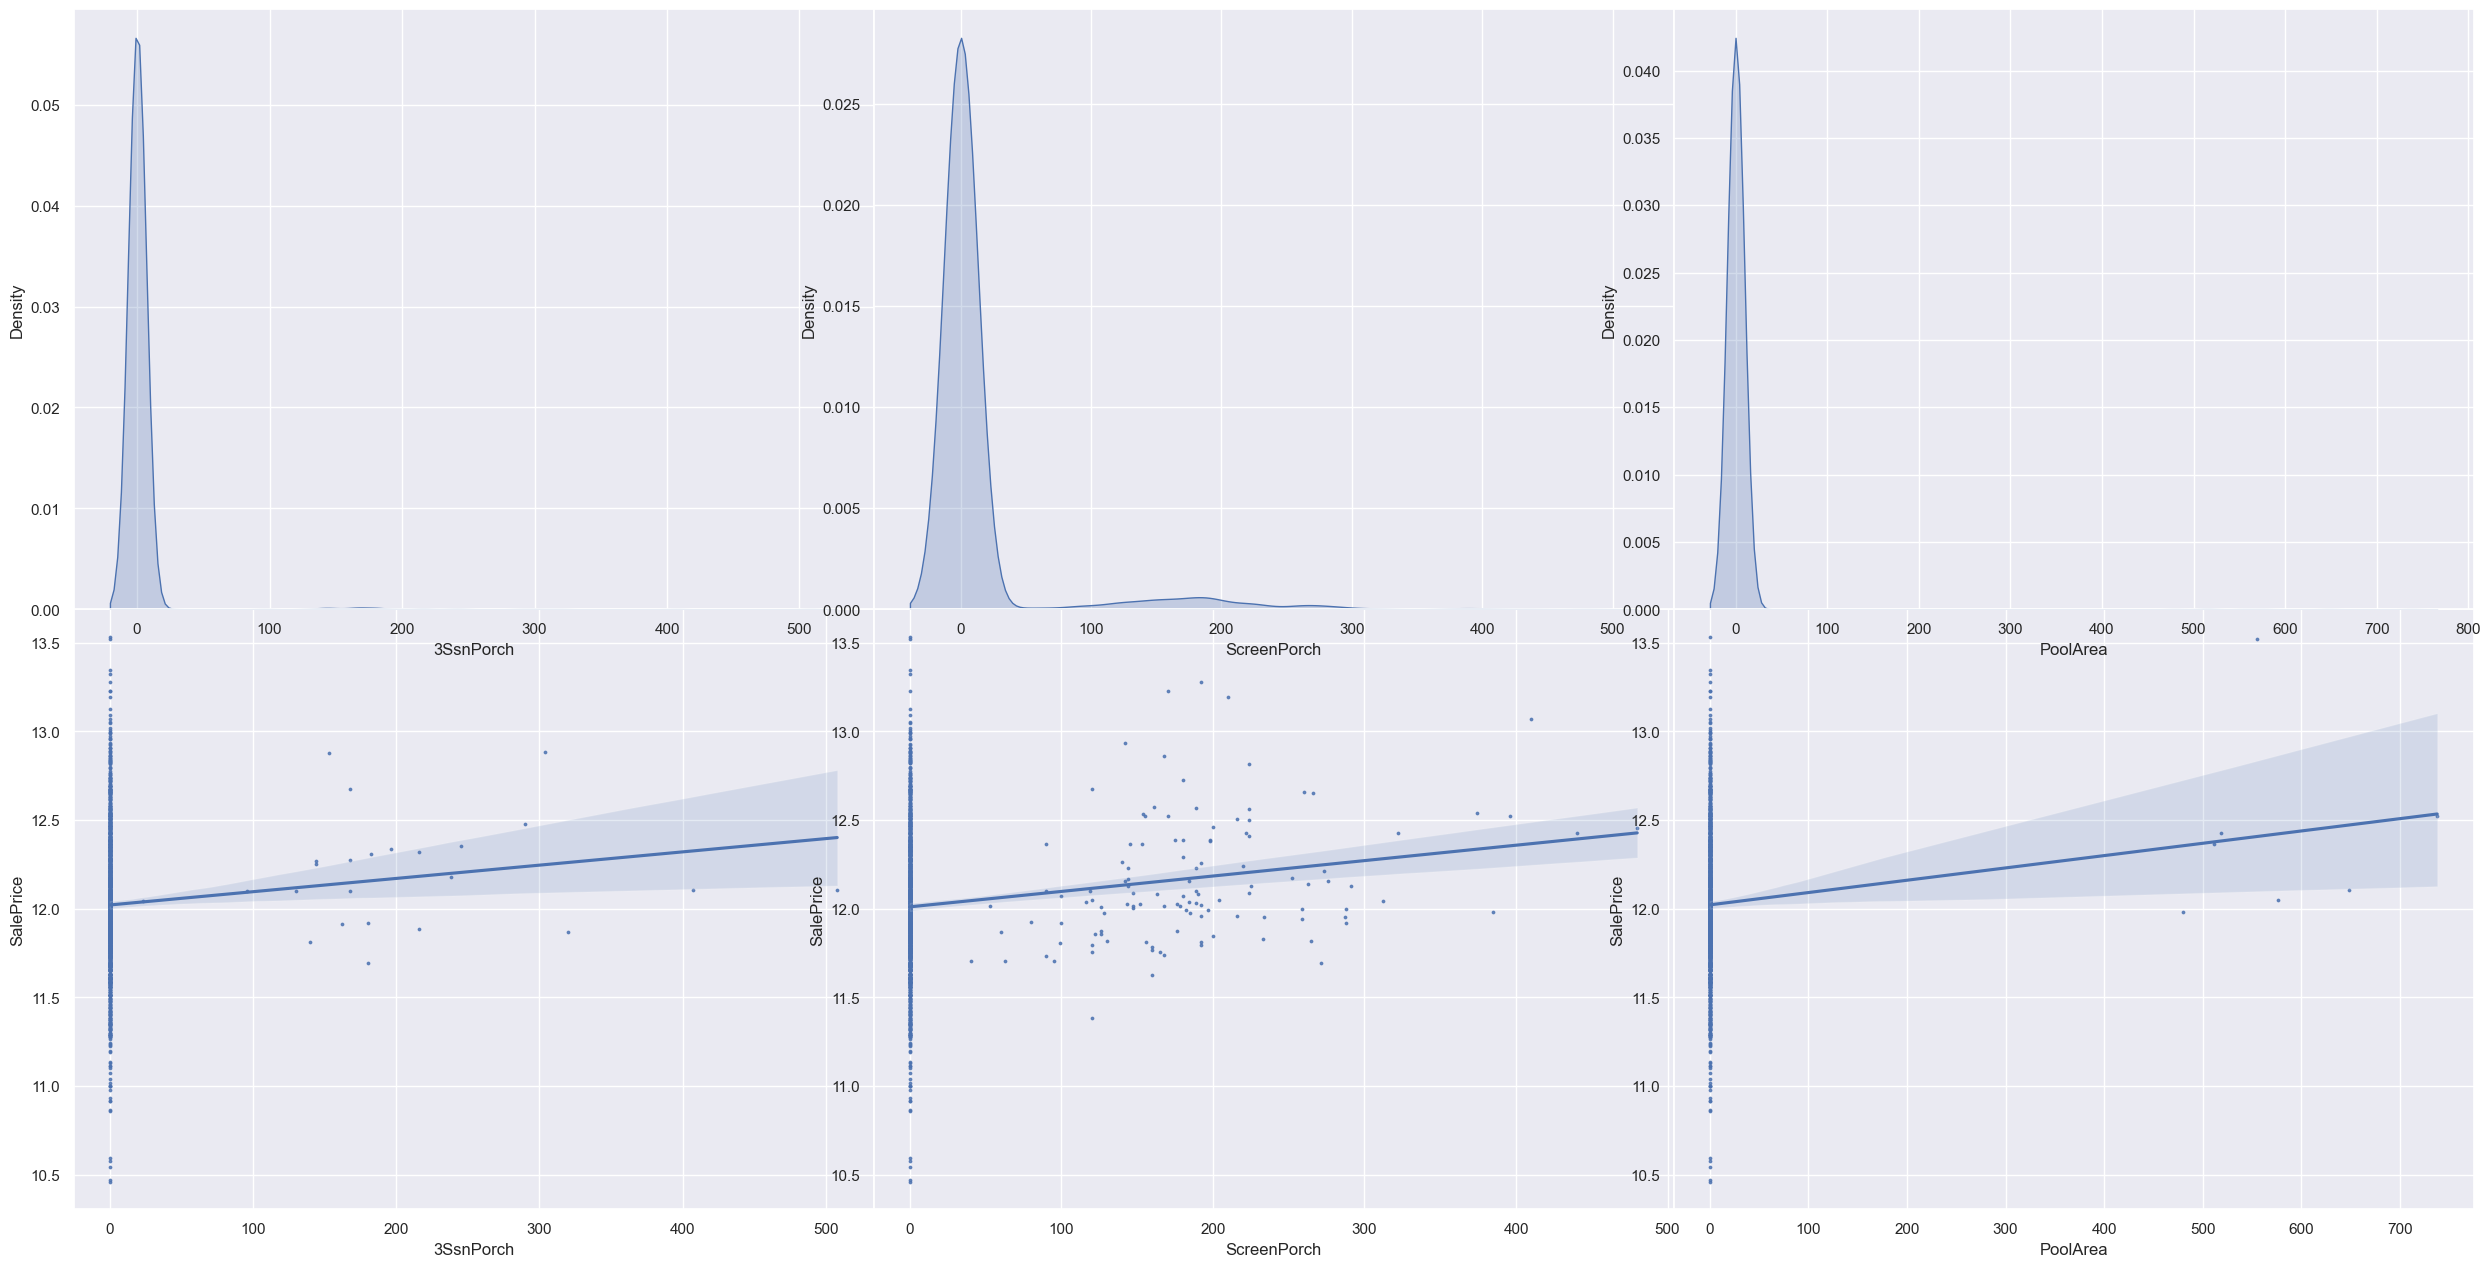

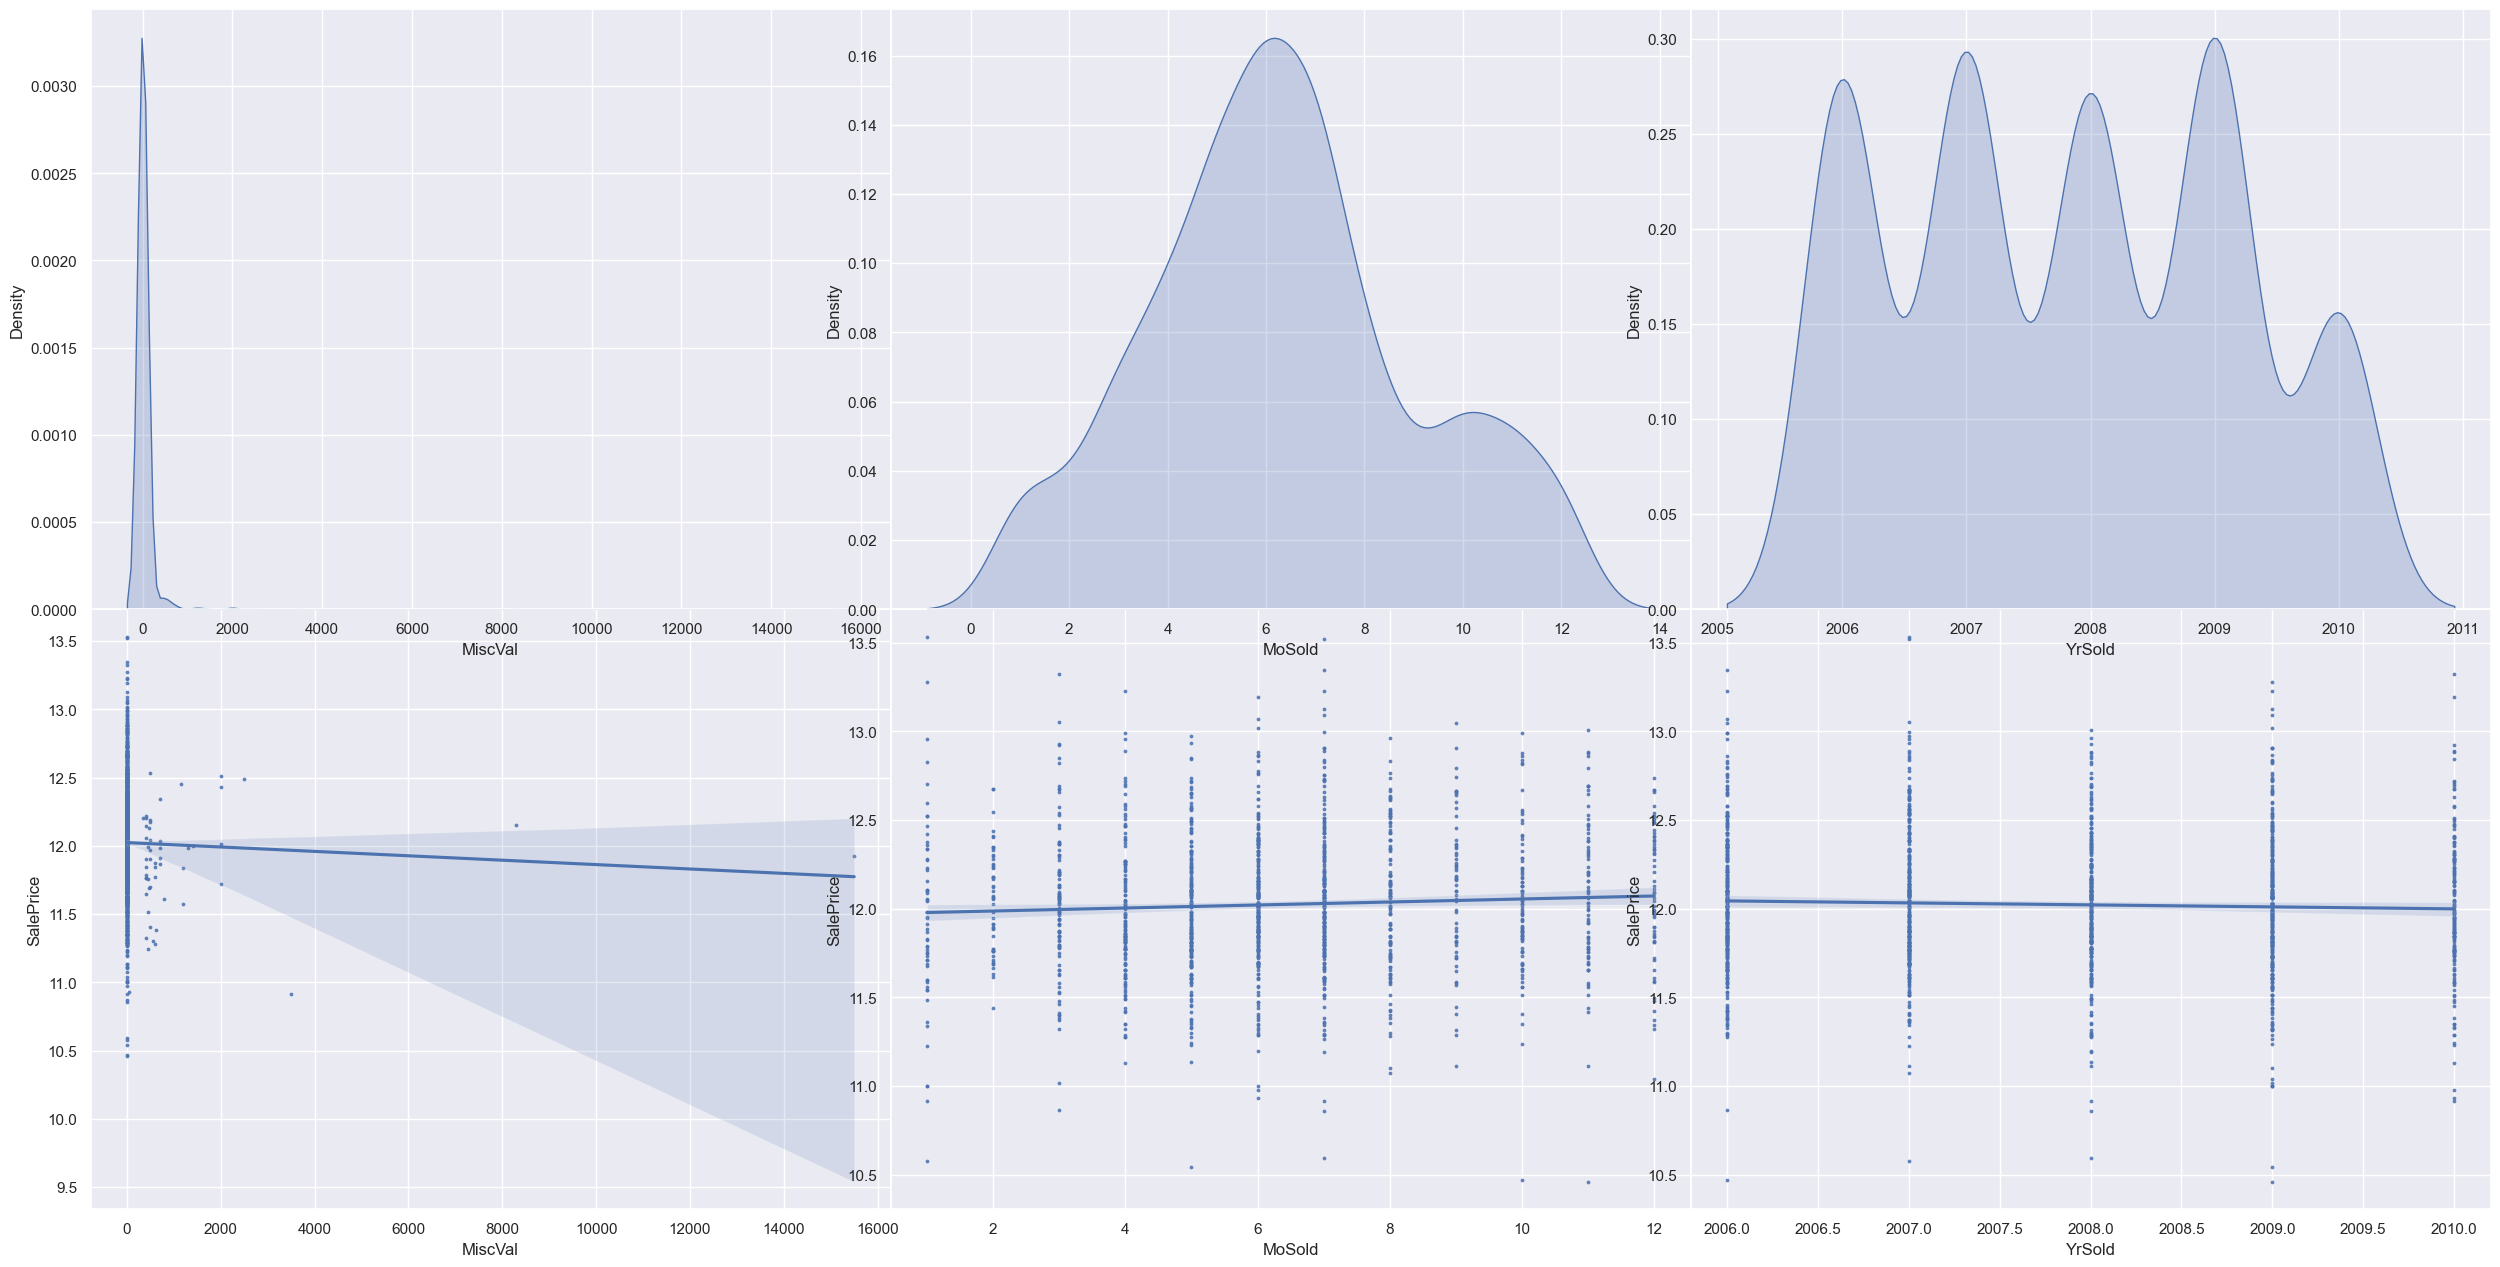

In [99]:
for i, num in enumerate(numeric_cols[:36:3]):
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_axes([0, 0, 1, 1])
    ax2 = fig.add_axes([0, 1, 1, 1])
    ax3 = fig.add_axes([1, 0, 1, 1])
    ax4 = fig.add_axes([1, 1, 1, 1])
    ax5 = fig.add_axes([2, 0, 1, 1])
    ax6 = fig.add_axes([2, 1, 1, 1])
    _ = sns.regplot(x = df_numeric[numeric_cols[i*3]], y = df_numeric["SalePrice"], ax = ax1, scatter_kws={'s':3})
    _ = sns.kdeplot(df_numeric[numeric_cols[i*3]], ax = ax2, fill = True)
    _ = sns.regplot(x = df_numeric[numeric_cols[i*3+1]], y = df_numeric["SalePrice"], ax = ax3, scatter_kws={'s':3})
    _ = sns.kdeplot(df_numeric[numeric_cols[i*3+1]], ax = ax4, fill = True)
    _ = sns.regplot(x = df_numeric[numeric_cols[i*3+2]], y = df_numeric["SalePrice"], ax = ax5, scatter_kws={'s':3})
    _ = sns.kdeplot(df_numeric[numeric_cols[i*3+2]], ax = ax6, fill = True)
    _ = plt.show()

In [100]:
# for i, num in enumerate(numeric_cols):
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), constrained_layout=True)
#     sns.kdeplot(df_numeric[num], ax = ax1, fill = True)
#     sns.regplot(x = df_numeric[num], y = df_numeric["SalePrice"], ax = ax2, scatter_kws={'s':3})
#     plt.show()

In [101]:
print(df_numeric[df_numeric['PoolArea'] == 0]['PoolArea'].count(),
    df_numeric[df_numeric['ScreenPorch'] == 0]['ScreenPorch'].count(),
    df_numeric[df_numeric['WoodDeckSF'] == 0]['WoodDeckSF'].count(),
    df_numeric[df_numeric['LowQualFinSF'] == 0]['LowQualFinSF'].count(),
    df_numeric[df_numeric['BsmtFinSF2'] == 0]['BsmtFinSF2'].count(),
    df_numeric[df_numeric['BsmtFinSF1'] == 0]['BsmtFinSF1'].count(), 
    df_numeric[df_numeric['MasVnrArea'] == 0]['MasVnrArea'].count())

1453 1344 761 1434 1293 467 869


In [102]:
zeros_in_cols = []
for col in df_numeric.columns:
    zeros_in_cols.append((col, df_numeric[df_numeric[col] == 0][col].count()))
pd.DataFrame(zeros_in_cols).sort_values(1, ascending=False).head(15)

0     1
32       PoolArea  1453
30      3SsnPorch  1436
14   LowQualFinSF  1434
33        MiscVal  1408
17   BsmtHalfBath  1378
31    ScreenPorch  1344
9      BsmtFinSF2  1293
29  EnclosedPorch  1252
19       HalfBath   913
7      MasVnrArea   869
16   BsmtFullBath   856
13       2ndFlrSF   829
27     WoodDeckSF   761
23     Fireplaces   690
28    OpenPorchSF   656

### Что я заметил отсюда
- MiscVal на самом делекатегориальная, дропнем
- YrSold тоже больше похожа на категориальную
- MoSold туда же 
- Почти ни у кого нет бассейна, PoolArea удаляем
- Почти ни у кого нет ScreenPorch веранды, дропаем ScreenPorch, 3SsnPorch, EnclosedPorch
- WoodDeckSF дропнем у половины этого нету, чем бы это ни было
- GarageArea и GarageCars про одно и то же, посмтори что из них больше коррелирует с целевой и дропнем одну из них 
- Много целочисленных фичей, если честно, то хз что с ними делать, пока оставлю как есть
- LowQualFinSF почти все нулевые, дропну
- BsmtFinSF2 почти все нулевые, дропну
- BsmtFinSF1 есть неслколько выбросов, надо почистить
- YearBuilt с 25 по 50  была великая депрессия и война, а почему в 80-ые дома не строили?..
- Вроде OverallCond и OverallQual похожие метрики, но цена от них ведет себя по разному, надо к ним присмотреться
- MSSubClass категориальная, дропнем
  - Можно все Area просуммировать и собрать в новую метрику TotalArea

In [103]:
to_drop = ['MiscVal', 'YrSold', 'MoSold', 'PoolArea', 'ScreenPorch', '3SsnPorch', 'EnclosedPorch',\
           'GarageCars', 'BsmtFinSF2', 'BsmtFinSF1','MSSubClass', 'BsmtHalfBath',\
           'BedroomAbvGr', 'LowQualFinSF', 'KitchenAbvGr']

In [104]:
df_numeric['TotalBsmtSF_log'] = np.log1p(df_numeric['TotalBsmtSF'])
df_numeric['TotalArea'] = df_numeric['TotalBsmtSF'] + df_numeric['1stFlrSF'] + df_numeric['2ndFlrSF'] 
df_numeric['LotArea_log'] = np.log1p(df_numeric['LotArea'])
df_numeric['OpenPorchSF_log'] = np.log1p(df_numeric['OpenPorchSF'])

### LotArea слишком перекошена, прологарифмируем ее

<AxesSubplot:xlabel='LotArea_log', ylabel='SalePrice'>

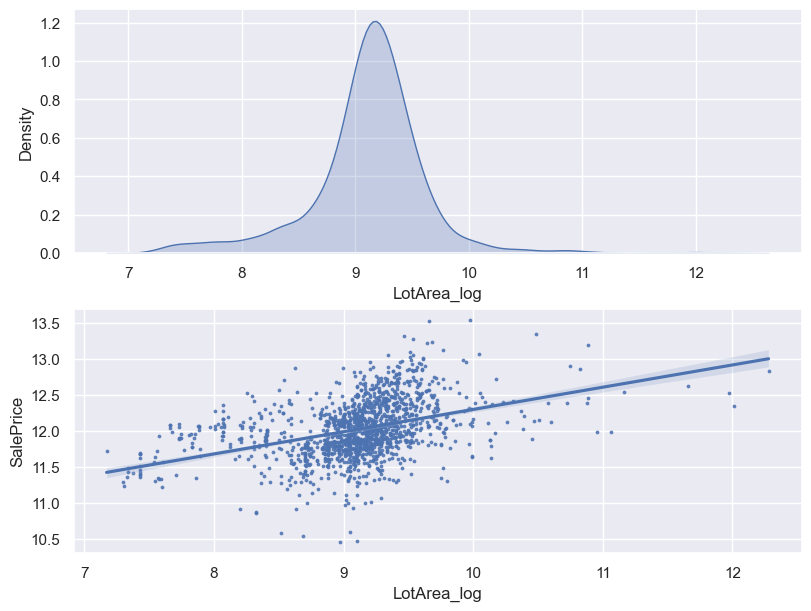

In [105]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), constrained_layout=True)
sns.kdeplot(df_numeric['LotArea_log'], ax = ax1, fill = True)
sns.regplot(x = df_numeric['LotArea_log'], y = df_numeric["SalePrice"], ax = ax2, scatter_kws={'s':3})

<AxesSubplot:xlabel='TotalArea', ylabel='SalePrice'>

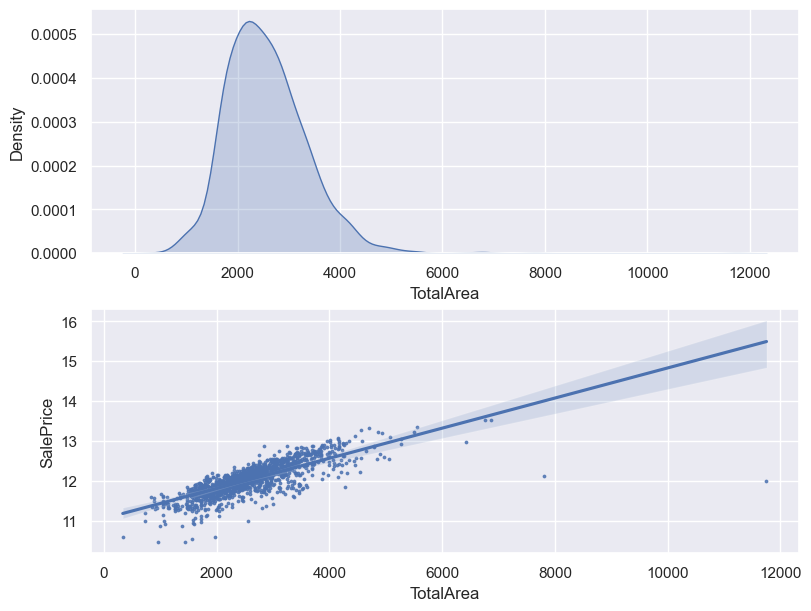

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), constrained_layout=True)
sns.kdeplot(df_numeric['TotalArea'], ax = ax1, fill = True)
sns.regplot(x = df_numeric['TotalArea'], y = df_numeric["SalePrice"], ax = ax2, scatter_kws={'s':3})

### Удалим два выбросв с большлй площадью и аномально низкой ценой 

In [107]:
df_numeric = df_numeric.drop(index = df_numeric[(df_numeric['TotalArea'] > 7000) & (df_numeric['SalePrice'] < 13)].index)

<AxesSubplot:xlabel='TotalArea', ylabel='SalePrice'>

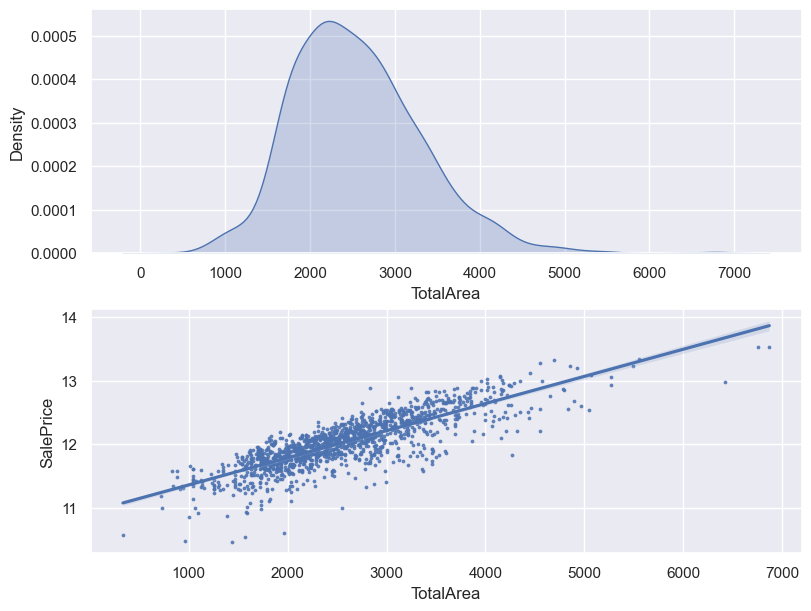

In [108]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), constrained_layout=True)
sns.kdeplot(df_numeric['TotalArea'], ax = ax1, fill = True)
sns.regplot(x = df_numeric['TotalArea'], y = df_numeric["SalePrice"], ax = ax2, scatter_kws={'s':3})

### Кайф

## Бейслайн модель

In [109]:
df_numeric.drop(columns = to_drop, inplace=True)

In [110]:
X_train = df_numeric.drop(columns = ['SalePrice'])
y_train = df_numeric['SalePrice']

In [111]:
X_train_normalized = (X_train - X_train.min())/ (X_train.max() - X_train.min())
X_train_normalized_c = sm.add_constant(X_train_normalized)
model_classic = sm.OLS(y_train, X_train_normalized_c).fit()
model_classic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     556.7
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:01:30   Log-Likelihood:                 970.49
No. Observations:                1458   AIC:                            -1891.
Df Residuals:                    1433   BIC:                            -1759.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.2583      0.040    259.322      0.000      10.181      10.336
LotFrontage         0.0287      0.033      0.879      0.380      -0.035       0.093
LotArea            -0.0621      0.102     -0.611      0.541      -0.262       0.137
OverallQual         0.7283      0.037     19.533      0.000       0.655       0.801
OverallCond         0.3956      0.029     13.560      0.000       0.338       0.453
YearBuilt           0.4055      0.029     14.083      0.000       0.349       0.462
YearRemodAdd        0.0865      0.014      6.095      0.000       0.059       0.114
MasVnrArea          0.0402      0.034      1.171      0.242      -0.027       0.107
BsmtUnfSF          -0.1501      0.027     -5.642      0.000      -0.202      -0.098
TotalBsmtSF         0.5363      0.085      6.347      0.000       0.371       0.702
1stFlrSF            0.0162      0.175      0.092      0.927      -0.328       0.360
2ndFlrSF            0.0517      0.120      0.431      0.666      -0.184       0.287
GrLivArea           0.7239      0.293      2.471      0.014       0.149       1.299
BsmtFullBath        0.0815      0.027      3.013      0.003       0.028       0.135
FullBath            0.0377      0.030      1.260      0.208      -0.021       0.097
HalfBath            0.0372      0.019      1.940      0.053      -0.000       0.075
TotRmsAbvGrd       -0.0168      0.046     -0.365      0.715      -0.107       0.074
Fireplaces          0.1224      0.019      6.482      0.000       0.085       0.159
GarageYrBlt         0.0670      0.019      3.589      0.000       0.030       0.104
GarageArea          0.1740      0.034      5.064      0.000       0.107       0.241
WoodDeckSF          0.0376      0.024      1.543      0.123      -0.010       0.085
OpenPorchSF         0.0075      0.047      0.161      0.872      -0.084       0.099
TotalBsmtSF_log    -0.0538      0.040     -1.341      0.180      -0.132       0.025
TotalArea           0.2865      0.091      3.155      0.002       0.108       0.465
LotArea_log         0.4821      0.053      9.157      0.000       0.379       0.585
OpenPorchSF_log     0.0094      0.018      0.530      0.596      -0.025       0.044
==============================================================================
Omnibus:                      372.150   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2368.779
Skew:                          -1.030   Prob(JB):                         0.00
Kurtosis:                       8.895   Cond. No.                     1.12e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.55e-29. This might indicate that there a

### Посмотрим, на взаимные корреляции, и поудаляем сильно скореллированыые переменные 

<AxesSubplot:>

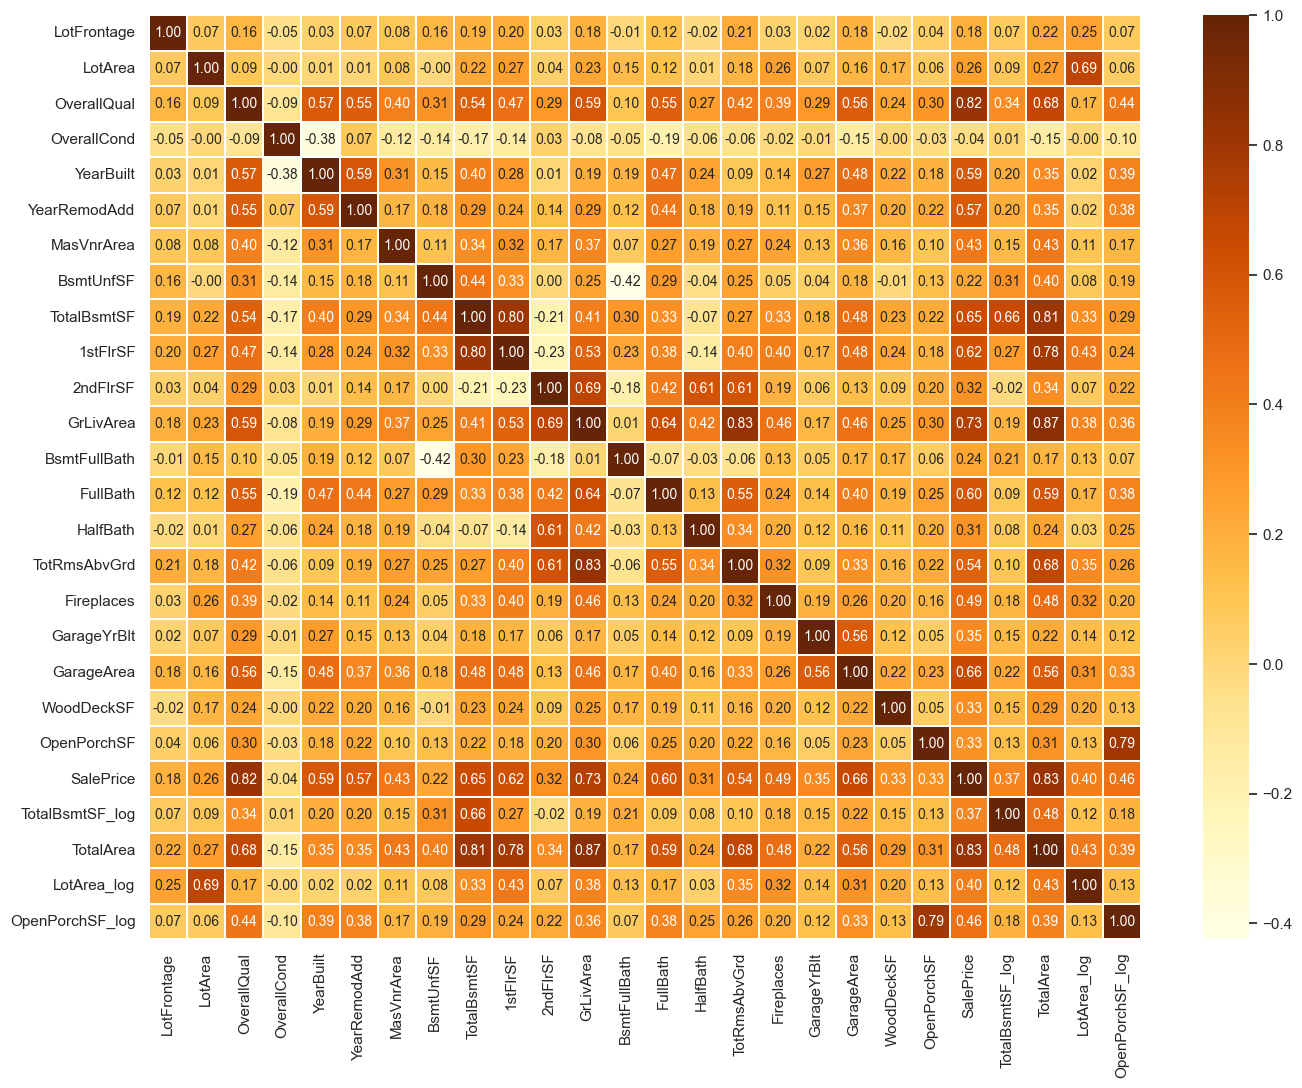

In [112]:
sns.set(rc={'figure.figsize':(16, 12)})
sns.heatmap(df_numeric.corr(), cmap="YlOrBr", linewidths=0.1, annot=True, annot_kws={"fontsize":10}, fmt=".2f")

In [113]:
sns.set(rc={'figure.figsize':(12, 8)})
correlations = df_numeric.corrwith(df_numeric.SalePrice).sort_values(ascending=False)
# plot = sns.barplot(y=correlations.index, x=correlations)
correlations[:20]

SalePrice          1.000000
TotalArea          0.825326
OverallQual        0.821405
GrLivArea          0.725211
GarageArea         0.656129
TotalBsmtSF        0.647563
1stFlrSF           0.620500
FullBath           0.595899
YearBuilt          0.587043
YearRemodAdd       0.565992
TotRmsAbvGrd       0.537702
Fireplaces         0.491998
OpenPorchSF_log    0.460623
MasVnrArea         0.430570
LotArea_log        0.402820
TotalBsmtSF_log    0.373312
GarageYrBlt        0.349013
WoodDeckSF         0.334251
OpenPorchSF        0.325215
2ndFlrSF           0.319953
dtype: float64

 ### Здесь функция которая смотрит взаимную корреляцию между фичами, и если она больше threshold то выкидывает ту фичу, у которой корреляция с таргетом меньше. Кажется, что когда фичей слишком много то это лучше vif-ов

In [114]:
def feature_selection(df, target, threshold):
    '''if correlation bettween two features is greater than threshod
       function adds feature with less correlation with target to out
       
       returns all features in out'''

    s = df.drop(columns=[target]).corr().abs().unstack()
    sorted_corrs = s.sort_values(kind="quicksort", ascending=False)
    sorted_corrs = sorted_corrs[(sorted_corrs < 1) & (sorted_corrs > threshold)]
    sorted_corrs = sorted_corrs.drop_duplicates()
    correlations = df.corrwith(df[target]).sort_values(ascending=False)
    out = []
    for ind, corr in enumerate(sorted_corrs):
        if correlations[sorted_corrs.index[ind][0]] > correlations[sorted_corrs.index[ind][1]]:
            out.append(sorted_corrs.index[ind][1])
        else:
            out.append(sorted_corrs.index[ind][0])
    return out

In [115]:
def get_vifs_30(df, target):
    '''returns vifs that greater then 30'''
    
    vifs = []
    X = df.drop(columns=[target]).copy()
    for col in X.columns:
        X_ = X.drop(columns=[col])
        results = sm.OLS(X[col], X_).fit()
        vif = 1 / (1 - results.rsquared)
        if vif > 30:
            vifs.append((col, 1 / (1 - results.rsquared)))
    return np.array(vifs)

#### Threshold = 0.7

In [116]:
out = feature_selection(df_numeric, 'SalePrice', 0.7)

In [117]:
def get_top_feats(df, out):
    return  list(set(df.columns) - set(out))

In [118]:
top_feats = get_top_feats(df_numeric, out)

<AxesSubplot:>

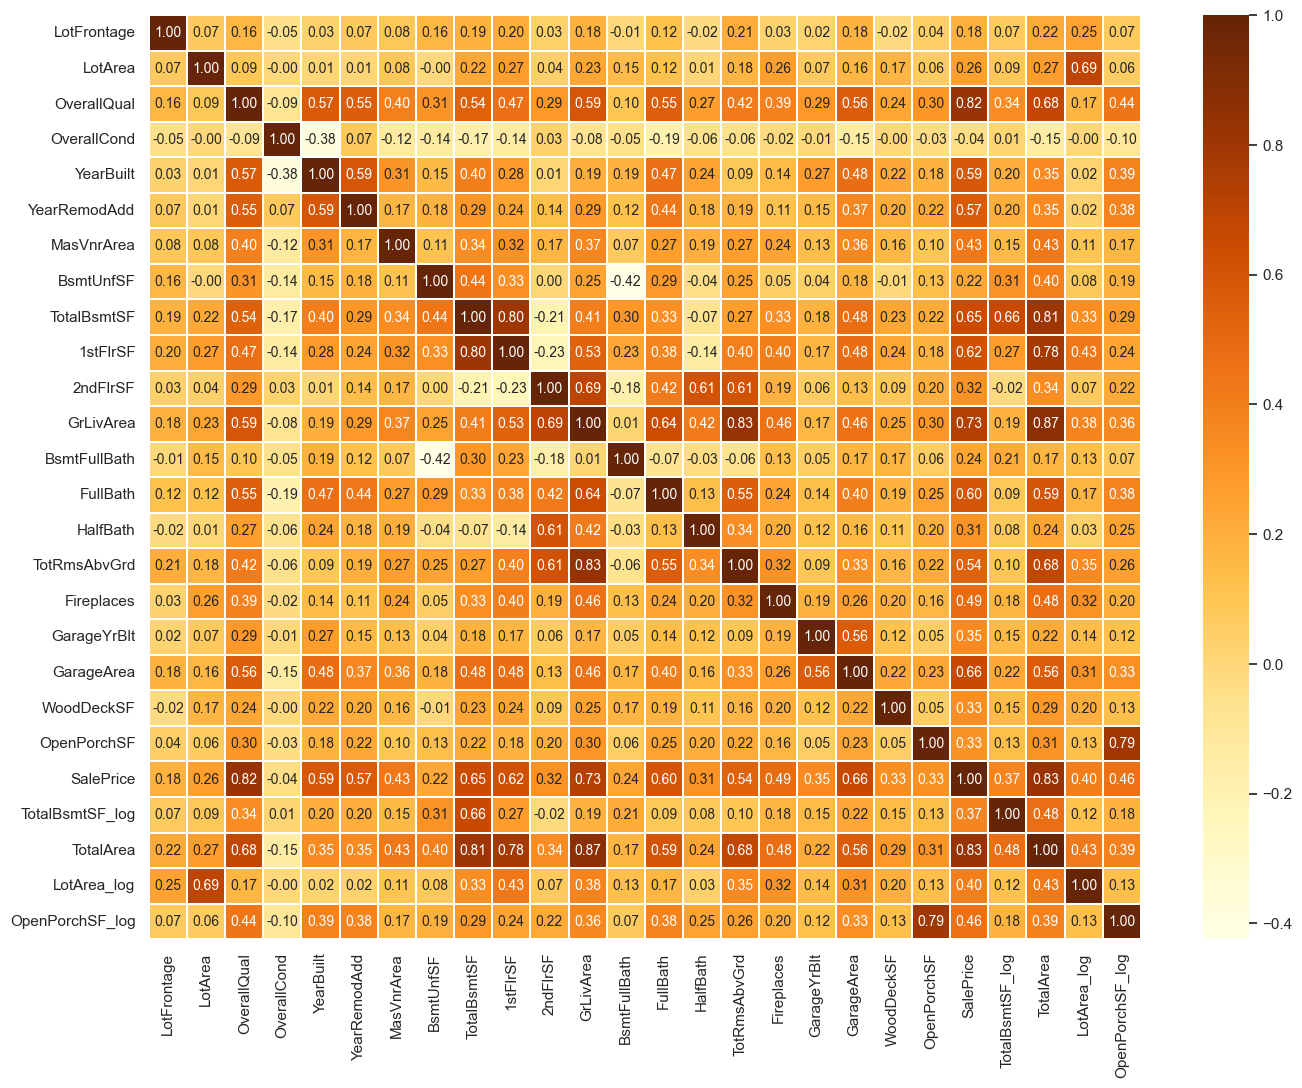

In [119]:
sns.set(rc={'figure.figsize':(16, 12)})
sns.heatmap(df_numeric.corr(), cmap="YlOrBr", linewidths=0.1, annot=True, annot_kws={"fontsize":10}, fmt=".2f")

In [120]:
df_numeric = df_numeric[top_feats]
X_train = df_numeric[top_feats].drop(columns = ['SalePrice'])
y_train = df_numeric['SalePrice']

X_train_normalized = (X_train - X_train.min())/ (X_train.max() - X_train.min())
X_train_normalized_c = sm.add_constant(X_train_normalized)
model_classic_1 = sm.OLS(y_train, X_train_normalized_c).fit()
model_classic_1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     666.7
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:01:43   Log-Likelihood:                 967.35
No. Observations:                1458   AIC:                            -1893.
Df Residuals:                    1437   BIC:                            -1782.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.2692      0.036    286.414      0.000      10.199      10.339
WoodDeckSF          0.0385      0.024      1.580      0.114      -0.009       0.086
OpenPorchSF_log     0.0125      0.011      1.100      0.272      -0.010       0.035
YearRemodAdd        0.0876      0.014      6.203      0.000       0.060       0.115
OverallQual         0.7337      0.037     19.727      0.000       0.661       0.807
FullBath            0.0395      0.030      1.339      0.181      -0.018       0.097
Fireplaces          0.1225      0.019      6.562      0.000       0.086       0.159
MasVnrArea          0.0357      0.034      1.041      0.298      -0.032       0.103
LotArea_log         0.4794      0.052      9.230      0.000       0.377       0.581
YearBuilt           0.3928      0.027     14.316      0.000       0.339       0.447
GarageYrBlt         0.0619      0.018      3.347      0.001       0.026       0.098
OverallCond         0.3918      0.029     13.446      0.000       0.335       0.449
GarageArea          0.1783      0.034      5.200      0.000       0.111       0.246
2ndFlrSF            0.0491      0.026      1.908      0.057      -0.001       0.100
HalfBath            0.0372      0.019      1.943      0.052      -0.000       0.075
TotalBsmtSF_log    -0.0574      0.030     -1.936      0.053      -0.116       0.001
BsmtFullBath        0.0798      0.027      2.978      0.003       0.027       0.132
TotalArea           1.4151      0.061     23.328      0.000       1.296       1.534
LotFrontage         0.0300      0.033      0.920      0.358      -0.034       0.094
LotArea            -0.0592      0.101     -0.586      0.558      -0.257       0.139
BsmtUnfSF          -0.1527      0.026     -5.883      0.000      -0.204      -0.102
==============================================================================
Omnibus:                      374.893   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2363.760
Skew:                          -1.041   Prob(JB):                         0.00
Kurtosis:                       8.880   Cond. No.                         75.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
sm.stats.diagnostic.het_white(model_classic_1.resid, X_train_normalized_c)

(284.98514417372826,
 0.007880823577345392,
 1.296090823848693,
 0.004026047254784786)

#### Ушла мультколлениарность, модель улучшилась по AIC BIC

## Итоговая модель по нумерик фичам


#### Уберем не стат занчимые коэффициенты

In [122]:
pvals = model_classic_1.pvalues
out = pvals[pvals.values > 0.05].index
top_feats = get_top_feats(df_numeric, out)

In [123]:
X_train = df_numeric[top_feats].drop(columns = ['SalePrice', 'BsmtFullBath'])
y_train = df_numeric['SalePrice']

X_train_normalized = (X_train - X_train.min())/ (X_train.max() - X_train.min())
X_train_normalized_c = sm.add_constant(X_train_normalized)
model_classic_numeric = sm.OLS(y_train, X_train_normalized_c).fit()
model_classic_numeric.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1304.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:01:44   Log-Likelihood:                 947.93
No. Observations:                1458   AIC:                            -1874.
Df Residuals:                    1447   BIC:                            -1816.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.2502      0.030    339.354      0.000      10.191      10.309
YearBuilt        0.4027      0.024     16.472      0.000       0.355       0.451
GarageYrBlt      0.0539      0.018      2.936      0.003       0.018       0.090
OverallCond      0.3761      0.029     12.979      0.000       0.319       0.433
YearRemodAdd     0.0982      0.014      7.080      0.000       0.071       0.125
OverallQual      0.7628      0.037     20.804      0.000       0.691       0.835
GarageArea       0.1902      0.034      5.635      0.000       0.124       0.256
Fireplaces       0.1256      0.019      6.766      0.000       0.089       0.162
TotalArea        1.5258      0.048     31.992      0.000       1.432       1.619
LotArea_log      0.4609      0.039     11.924      0.000       0.385       0.537
BsmtUnfSF       -0.2206      0.020    -11.206      0.000      -0.259      -0.182
==============================================================================
Omnibus:                      382.657   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2396.594
Skew:                          -1.068   Prob(JB):                         0.00
Kurtosis:                       8.906   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

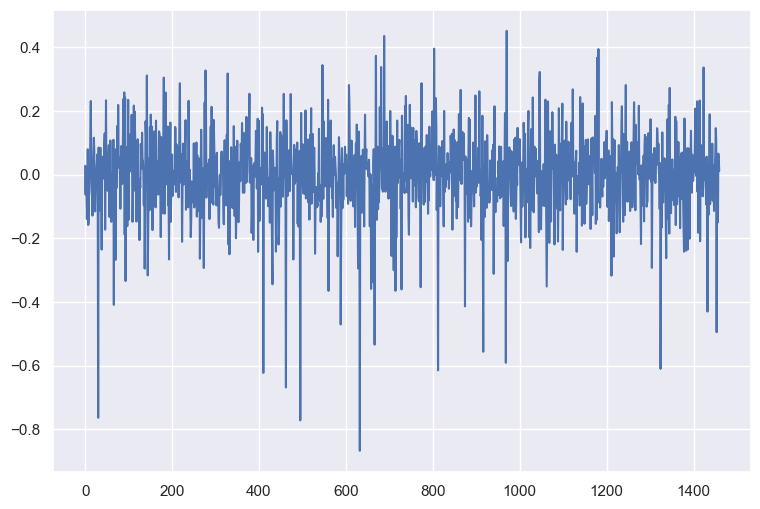

In [124]:
sns.set(rc={'figure.figsize':(9, 6)})
plt.plot(model_classic_numeric.resid)

In [125]:
sm.stats.diagnostic.het_white(model_classic_numeric.resid, X_train_normalized_c)

(118.10433674686738,
 6.273656869927946e-05,
 1.8876468262001107,
 3.7448915991630674e-05)

### Есть гетероскедастичность, ну, что поделать, не вижу тут какие фичи можно трансформировать. Мейби из-за того, что много выбросов в данных

In [126]:
numeric_last = df_numeric[top_feats]

## Categorical

#### Не особо понимаю как работать с категориальными переменными, поэтому рассмотрю только район в котором находится дом и разные quality с оценкой Ex

In [127]:
total = df_categorical.isnull().sum().sort_values(ascending=False)
percent = (df_categorical.isnull().sum()/df_categorical.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total  Percent
Neighborhood_Blmngtn      0      0.0
ExterCond_Ex              0      0.0
Neighborhood_SawyerW      0      0.0
Neighborhood_Somerst      0      0.0
Neighborhood_StoneBr      0      0.0
Neighborhood_Timber       0      0.0
Neighborhood_Veenker      0      0.0
ExterQual_Ex              0      0.0
BsmtQual_Ex               0      0.0
Neighborhood_SWISU        0      0.0
HeatingQC_Ex              0      0.0
KitchenQual_Ex            0      0.0
FireplaceQu_Ex            0      0.0
GarageQual_Ex             0      0.0
GarageCond_Ex             0      0.0
PoolQC_Ex                 0      0.0
Neighborhood_Sawyer       0      0.0
Neighborhood_OldTown      0      0.0
Neighborhood_Blueste      0      0.0
Neighborhood_Gilbert      0      0.0

In [128]:
correlations = df_categorical.corrwith(df_categorical.SalePrice).sort_values(ascending=False).abs()[:15]
correlations

SalePrice               1.000000
HeatingQC_Ex            0.466706
BsmtQual_Ex             0.463991
KitchenQual_Ex          0.413937
ExterQual_Ex            0.356134
Neighborhood_NridgHt    0.351803
Neighborhood_NoRidge    0.277523
FireplaceQu_Ex          0.209134
Neighborhood_StoneBr    0.185579
Neighborhood_Somerst    0.170694
Neighborhood_Timber     0.138945
Neighborhood_CollgCr    0.118290
Neighborhood_Crawfor    0.087003
PoolQC_Ex               0.085349
Neighborhood_Gilbert    0.078915
dtype: float64

In [129]:
top_feats = correlations[:6].index

In [130]:
df_categorical = df_categorical.fillna(0)

In [131]:
top_feats =df_categorical.corrwith(df_numeric.SalePrice).abs().sort_values(ascending=False)[:10].index

In [132]:
X_train = df_categorical[top_feats].drop(columns = ['SalePrice'])
y_train = df_categorical['SalePrice']
X_train_c = sm.add_constant(X_train)
model_classic_cat = sm.OLS(y_train, X_train_c).fit()
model_classic_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     177.8
Date:                Fri, 03 Mar 2023   Prob (F-statistic):          6.66e-227
Time:                        23:01:47   Log-Likelihood:                -188.49
No. Observations:                1460   AIC:                             397.0
Df Residuals:                    1450   BIC:                             449.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   11.9015      0.011   1055.521      0.000      11.879      11.924
BsmtQual_Ex              0.2775      0.034      8.100      0.000       0.210       0.345
HeatingQC_Ex             0.2169      0.015     14.045      0.000       0.187       0.247
KitchenQual_Ex           0.2646      0.037      7.159      0.000       0.192       0.337
ExterQual_Ex             0.1321      0.051      2.599      0.009       0.032       0.232
Neighborhood_NridgHt     0.1517      0.038      3.961      0.000       0.077       0.227
Neighborhood_NoRidge     0.5006      0.044     11.263      0.000       0.413       0.588
Neighborhood_IDOTRR     -0.5015      0.046    -10.810      0.000      -0.592      -0.410
Neighborhood_OldTown    -0.2757      0.028    -10.025      0.000      -0.330      -0.222
Neighborhood_Edwards    -0.3113      0.029    -10.773      0.000      -0.368      -0.255
==============================================================================
Omnibus:                       46.645   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.664
Skew:                          -0.156   Prob(JB):                     5.09e-23
Kurtosis:                       4.261   Cond. No.                         8.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
categorical_last = df_categorical[top_feats]

In [134]:
last = pd.concat([numeric_last, categorical_last.drop(columns=['SalePrice'])], axis=1).dropna()
last

YearBuilt  GarageYrBlt  OverallCond  YearRemodAdd  OverallQual  \
0        2003.0       2003.0          5.0        2003.0          7.0   
1        1976.0       1976.0          8.0        1976.0          6.0   
2        2001.0       2001.0          5.0        2002.0          7.0   
3        1915.0       1998.0          5.0        1970.0          7.0   
4        2000.0       2000.0          5.0        2000.0          8.0   
...         ...          ...          ...           ...          ...   
1455     1999.0       1999.0          5.0        2000.0          6.0   
1456     1978.0       1978.0          6.0        1988.0          6.0   
1457     1941.0       1941.0          9.0        2006.0          7.0   
1458     1950.0       1950.0          6.0        1996.0          5.0   
1459     1965.0       1965.0          6.0        1965.0          5.0   

      GarageArea  SalePrice  BsmtFullBath  Fireplaces  TotalArea  ...  \
0          548.0  12.247699           1.0         0.0     2566.0  ...   
1          460.0  12.109016           0.0         1.0     2524.0  ...   
2          608.0  12.317171           1.0         1.0     2706.0  ...   
3          642.0  11.849405           1.0         1.0     2473.0  ...   
4          836.0  12.429220           1.0         1.0     3343.0  ...   
...          ...        ...           ...         ...        ...  ...   
1455       460.0  12.072547           0.0         1.0     2600.0  ...   
1456       500.0  12.254868           1.0         2.0     3615.0  ...   
1457       252.0  12.493133           0.0         2.0     3492.0  ...   
1458       240.0  11.864469           1.0         0.0     2156.0  ...   
1459       276.0  11.901590           1.0         0.0     2512.0  ...   

      BsmtUnfSF  BsmtQual_Ex  HeatingQC_Ex  KitchenQual_Ex  ExterQual_Ex  \
0         150.0            0             1               0             0   
1         284.0            0             1               0             0   
2         434.0            0             1               0             0   
3         540.0            0             0               0             0   
4         490.0            0             1               0             0   
...         ...          ...           ...             ...           ...   
1455      953.0            0             1               0             0   
1456      589.0            0             0               0             0   
1457      877.0            0             1               0             1   
1458        0.0            0             0               0             0   
1459      136.0            0             0               0             0   

      Neighborhood_NridgHt  Neighborhood_NoRidge  Neighborhood_IDOTRR  \
0                        0                     0                    0   
1                        0                     0                    0   
2                        0                     0                    0   
3                        0                     0                    0   
4                        0                     1                    0   
...                    ...                   ...                  ...   
1455                     0                     0                    0   
1456                     0                     0                    0   
1457                     0                     0                    0   
1458                     0                     0                    0   
1459                     0                     0                    0   

      Neighborhood_OldTown  Neighborhood_Edwards  
0                        0                     0  
1                        0                     0  
2                        0                     0  
3                        0                     0  
4                        0                     0  
...                    ...                   ...  
1455                     0                     0  
1456                     0                     0  
1457           

## Combined

In [135]:
X_train = last.drop(columns = ['SalePrice'])
y_train = last['SalePrice']
X_train_c = sm.add_constant(X_train)
model_classic_final_1 = sm.OLS(y_train, X_train_c).fit()
model_classic_final_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     699.6
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:01:48   Log-Likelihood:                 999.08
No. Observations:                1458   AIC:                            -1956.
Df Residuals:                    1437   BIC:                            -1845.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    2.5578      0.466      5.489      0.000       1.644       3.472
YearBuilt                0.0022      0.000     10.863      0.000       0.002       0.003
GarageYrBlt           3.067e-05   9.05e-06      3.389      0.001    1.29e-05    4.84e-05
OverallCond              0.0455      0.004     12.747      0.000       0.038       0.052
YearRemodAdd             0.0014      0.000      6.158      0.000       0.001       0.002
OverallQual              0.0772      0.004     18.553      0.000       0.069       0.085
GarageArea               0.0001   2.41e-05      5.299      0.000    8.06e-05       0.000
BsmtFullBath            -0.0010      0.008     -0.124      0.902      -0.016       0.014
Fireplaces               0.0379      0.006      6.264      0.000       0.026       0.050
TotalArea                0.0002   7.61e-06     29.246      0.000       0.000       0.000
LotArea_log              0.0890      0.007     12.013      0.000       0.074       0.104
BsmtUnfSF             -9.07e-05   9.89e-06     -9.169      0.000      -0.000   -7.13e-05
BsmtQual_Ex              0.0505      0.016      3.189      0.001       0.019       0.081
HeatingQC_Ex             0.0418      0.008      5.252      0.000       0.026       0.057
KitchenQual_Ex           0.0454      0.017      2.698      0.007       0.012       0.078
ExterQual_Ex             0.0051      0.023      0.221      0.825      -0.040       0.050
Neighborhood_NridgHt     0.0207      0.017      1.186      0.236      -0.014       0.055
Neighborhood_NoRidge     0.0257      0.021      1.217      0.224      -0.016       0.067
Neighborhood_IDOTRR     -0.1206      0.022     -5.477      0.000      -0.164      -0.077
Neighborhood_OldTown    -0.0656      0.015     -4.430      0.000      -0.095      -0.037
Neighborhood_Edwards    -0.0355      0.014     -2.584      0.010      -0.062      -0.009
==============================================================================
Omnibus:                      371.853   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2178.285
Skew:                          -1.054   Prob(JB):                         0.00
Kurtosis:                       8.604   Cond. No.                     6.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [136]:
get_vifs_30(last, 'SalePrice')

array([['YearBuilt', '12613.660386074256'],
       ['OverallCond', '39.58680371110757'],
       ['YearRemodAdd', '13531.821685423665'],
       ['OverallQual', '58.54482971962562'],
       ['TotalArea', '39.911338843610956'],
       ['LotArea_log', '413.99735768238537']], dtype='<U32')

In [137]:
top_feats =last.corrwith(df_numeric.SalePrice).abs().sort_values(ascending=False)[:12].index

In [138]:
X_train = last[top_feats].drop(columns = ['SalePrice', 'YearRemodAdd'])
y_train = last['SalePrice']
X_train_c = sm.add_constant(X_train)
model_classic_final_3 = sm.OLS(y_train, X_train_c).fit()
model_classic_final_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     966.8
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:01:48   Log-Likelihood:                 754.98
No. Observations:                1458   AIC:                            -1488.
Df Residuals:                    1447   BIC:                            -1430.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3885      0.335     16.069      0.000       4.731       6.046
TotalArea          0.0002   7.83e-06     23.594      0.000       0.000       0.000
OverallQual        0.0912      0.005     19.558      0.000       0.082       0.100
GarageArea         0.0002   2.39e-05      7.695      0.000       0.000       0.000
YearBuilt          0.0023      0.000     13.805      0.000       0.002       0.003
Fireplaces         0.0536      0.007      7.775      0.000       0.040       0.067
BsmtQual_Ex        0.0274      0.018      1.520      0.129      -0.008       0.063
HeatingQC_Ex       0.0547      0.009      6.143      0.000       0.037       0.072
KitchenQual_Ex     0.0496      0.020      2.537      0.011       0.011       0.088
LotArea_log        0.0989      0.009     11.492      0.000       0.082       0.116
ExterQual_Ex       0.0167      0.027      0.624      0.533      -0.036       0.069
==============================================================================
Omnibus:                      413.690   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2220.162
Skew:                          -1.218   Prob(JB):                         0.00
Kurtosis:                       8.533   Cond. No.                     2.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Метрики лучше от того что фичей больше, но из-за мультиколлинеарности некоторые важные коэффициенты уезжают в ноль. Так что предпочту использовать просто нумерик фичи

## Итого

In [139]:
model_classic_numeric.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1304.
Date:                Fri, 03 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:01:49   Log-Likelihood:                 947.93
No. Observations:                1458   AIC:                            -1874.
Df Residuals:                    1447   BIC:                            -1816.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.2502      0.030    339.354      0.000      10.191      10.309
YearBuilt        0.4027      0.024     16.472      0.000       0.355       0.451
GarageYrBlt      0.0539      0.018      2.936      0.003       0.018       0.090
OverallCond      0.3761      0.029     12.979      0.000       0.319       0.433
YearRemodAdd     0.0982      0.014      7.080      0.000       0.071       0.125
OverallQual      0.7628      0.037     20.804      0.000       0.691       0.835
GarageArea       0.1902      0.034      5.635      0.000       0.124       0.256
Fireplaces       0.1256      0.019      6.766      0.000       0.089       0.162
TotalArea        1.5258      0.048     31.992      0.000       1.432       1.619
LotArea_log      0.4609      0.039     11.924      0.000       0.385       0.537
BsmtUnfSF       -0.2206      0.020    -11.206      0.000      -0.259      -0.182
==============================================================================
Omnibus:                      382.657   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2396.594
Skew:                          -1.068   Prob(JB):                         0.00
Kurtosis:                       8.906   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Nice $BIC$ $AIC$, awesome $R^2$, good Cond. No.

### Интерпритация 

In [140]:
params = model_classic_numeric.params.sort_values(ascending=False)
df_params = pd.DataFrame({'variable': params.index, 'weight':params.values })
df_params['interpiatation'] = ['минимальная цена 10 процентов от максимальной',\
                                'самая важная фича, при увеличении на один процент увеличивает цену на полтора',\
                                '1 пункт добавляет 0.7 процента к цене',\
                                'размер участка при увеличении на проуент увеличивает цену на 0.7 процента',\
                                'чем моложе дом тем выше цена)',\
                                'один пункт увеличивает цену на 0.4 процента',\
                                'увеличение площади гаража на один процент влечет увеличение цены на 0.4 процента',\
                                'чем больше каминов тем выше цена)',\
                                'Дата реконстукции также положительно влияет на цену',\
                                'Дата постройки гаража также положительно влияет на цену',\
                                'американцы любят подвалы с законченным ремонтом']
df_params

variable     weight                                     interpiatation
0          const  10.250203      минимальная цена 10 процентов от максимальной
1      TotalArea   1.525843  самая важная фича, при увеличении на один проц...
2    OverallQual   0.762786              1 пункт добавляет 0.7 процента к цене
3    LotArea_log   0.460885  размер участка при увеличении на проуент увели...
4      YearBuilt   0.402723                      чем моложе дом тем выше цена)
5    OverallCond   0.376073        один пункт увеличивает цену на 0.4 процента
6     GarageArea   0.190209  увеличение площади гаража на один процент влеч...
7     Fireplaces   0.125606                  чем больше каминов тем выше цена)
8   YearRemodAdd   0.098188  Дата реконстукции также положительно влияет на...
9    GarageYrBlt   0.053928  Дата постройки гаража также положительно влияе...
10     BsmtUnfSF  -0.220633    американцы любят подвалы с законченным ремонтом